# TP : Finite difference method for HJB equations

- Nom et prénom: **UTH Rathea**

- NumeroEtudiant: **22106760**

- Nom et prénom: **Nouredine Larbi**

- NumeroEtudiant: **22118105**

## Importing libraries

In [1]:
import numpy as np  # array
import pandas as pd
from scipy.stats import norm
import numpy.linalg as lng  # linear algebra
import scipy.linalg as slng
import matplotlib.pyplot as plt  # plot functions
import time
import sys  # command sys.exit()
from scipy.sparse import csr_matrix as sparse 
from scipy.sparse.linalg import spsolve

# 1. An Eikonal equation

## 1.1. Programming EE scheme

In [2]:
def Euler_EE(c, T, Smin, Smax, I, N):
    
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(1, (I+1))      
    dt = T/N
    
    def vleft(t):
        return 0.0
    
    def vright(t):
        return 0.0
    
    # the matrix D^-
    def get_D1(): 
        D = np.zeros((I,I))
        for i in range(0, I):
            D[i, i] = c/h
        for i in range(1, I):
            D[i, i-1] = -c/h
        
        return D
    
    # the matrix D^+
    def get_D2(): 
        D = np.zeros((I,I))
        for i in range(0, I):
            D[i, i] = -c/h
        for i in range(0, I-1):
            D[i, i+1] = c/h
        
        return D
    
    
    # the vector function q^-(t)
    def get_Q1(t):
        Q = np.zeros((I,1))
        Q[0] = -(c/h)*vleft(t)
        
        return Q
    
    # the vector function q^+(t)
    def get_Q2(t):
        Q = np.zeros((I,1))
        Q[I-1] = (c/h)*vright(t)
        
        return Q
        
    def v0(x):
        res = -(np.maximum(1 - abs(x)**2, 0))**2
        return res.reshape(I,1)
    
    # initialization
    U = v0(s)
    Id = np.eye(I)
    
    # main loop 
    for n in range(0, N):
        t = n*dt 
        U = U - dt*np.maximum(get_D1()@U + get_Q1(t), -(get_D2()@U + get_Q2(t)))
        
    U = np.insert(U, 0, vleft(T))
    U = np.insert(U, U.size, vright(T))

    return U

In [3]:
Euler_EE(c=1, T=1, Smin=-3, Smax=3, I=20, N=20)

array([ 0.        , -0.01885399, -0.0537854 , -0.12936121, -0.26223594,
       -0.44882719, -0.65294513, -0.82050946, -0.91770752, -0.9533447 ,
       -0.95960017, -0.95960017, -0.9533447 , -0.91770752, -0.82050946,
       -0.65294513, -0.44882719, -0.26223594, -0.12936121, -0.0537854 ,
       -0.01885399,  0.        ])

In [4]:
def exact_solution(c, t, x):
    
    def v0(x):
        res = -(np.maximum(1 - abs(x)**2, 0))**2
        return res
    
    if (x <= -c*t):
        return v0(x + c*t)
    elif (x >= c*t):
        return v0(x - c*t)
    else:
        return v0(0)

In [26]:
def plot_EE(c, T, Smin, Smax, I, N, titles="Euler EE"):
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(0, (I+2))
    
    def v0(x):
        res = -(np.maximum(1 - x**2, 0))**2
        return res
    
    def exact_solution(c, t, x):
        if (x <= -c*t):
            return v0(x + c*t)
        elif (x >= c*t):
            return v0(x - c*t)
        else:
            return v0(0)
    
    vect_sol_exact = [exact_solution(c, T, x) for x in list(s)]
    
    U = Euler_EE(c, T, Smin, Smax, I, N)
    # Plot the data
    plt.figure(figsize=(8,5))
    plt.plot(s, U, "r", label="Scheme EE")
    plt.plot(s, vect_sol_exact, "b", ls="--", label="Exact")
    plt.plot(s, v0(s), "black", ls="--", label="v0")

    # Show the major grid lines with dark grey lines
    plt.grid(b=True, which='major', color='#666666', linestyle='--')

    # Show the minor grid lines with very faint and almost transparent grey lines
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
    plt.title(titles)
    plt.xlabel("S", fontsize=14)
    plt.ylabel("v(t,S)", fontsize=14)
    plt.legend(fontsize=11)

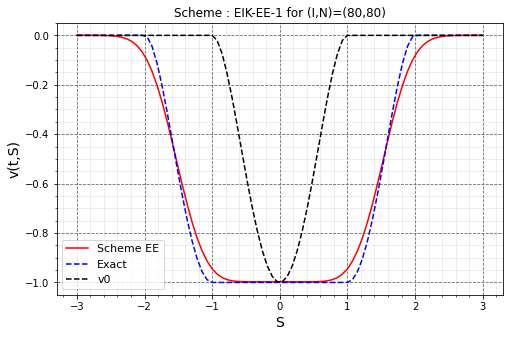

In [27]:
plot_EE(c=1.0, T=1, Smin=-3, Smax=3, I=80, N=80, titles="Scheme : EIK-EE-1 for (I,N)=(80,80)")

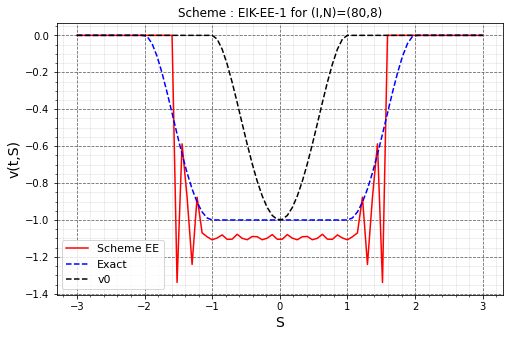

In [28]:
plot_EE(c=1.0, T=1, Smin=-3, Smax=3, I=80, N=8, titles="Scheme : EIK-EE-1 for (I,N)=(80,8)")

### Program with sparse matrix

In [8]:
def Euler_EE(c, T, Smin, Smax, I, N):
    
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(1, (I+1))      
    dt = T/N
    
    def vleft(t):
        return 0.0
    
    def vright(t):
        return 0.0
    
    # D_
    def get_D1(): 
        D = np.zeros((I,I))
        for i in range(0, I):
            D[i, i] = c/h
        for i in range(1, I):
            D[i, i-1] = -c/h
        
        return sparse(D)
    
    # D+
    def get_D2(): 
        D = np.zeros((I,I))
        for i in range(0, I):
            D[i, i] = -c/h
        for i in range(0, I-1):
            D[i, i+1] = c/h
        
        return sparse(D)
    
    
    # q_
    def get_Q1(t):
        Q = np.zeros((I,1))
        Q[0] = -(c/h)*vleft(t)
        
        return Q
    
    # q+
    def get_Q2(t):
        Q = np.zeros((I,1))
        Q[I-1] = (c/h)*vright(t)
        
        return Q
        
    def v0(x):
        res = -(np.maximum(1 - abs(x)**2, 0))**2
        return res.reshape(I,1)
    
    #init
    U = v0(s)
    Id = np.eye(I)
    
    # main loop 
    for n in range(0, N):
        t = n*dt 
        U = U - dt*np.maximum(get_D1()@U + get_Q1(t), -(get_D2()@U + get_Q2(t)))
        
    U = np.insert(U, 0, vleft(T))
    U = np.insert(U, U.size, vright(T))

    return U

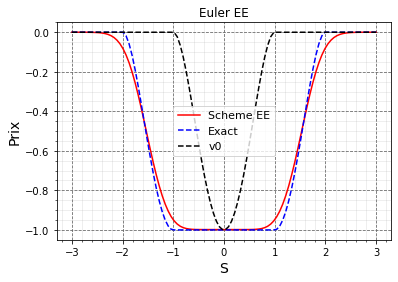

In [9]:
plot_EE(c=1.0, T=1, Smin=-3, Smax=3, I=100, N=1000)

In [10]:
def U_s_barre_EE(s_barre, c, T, Smin, Smax, I, N):
    h = (Smax - Smin)/(I+1)
    S_vect = Smin + h*np.arange(0, (I+2)) 
    U_vect = Euler_EE(c, T, Smin, Smax, I, N)
    
    s_i = 0
    s_i_plus_1 = 0
    u_i = 0
    u_i_plus_1 = 0
    
    for i in range(S_vect.size):     
        if s_barre < S_vect[i]:
            s_i = S_vect[i-1]
            s_i_plus_1 = S_vect[i]
            u_i = U_vect[i-1]
            u_i_plus_1 = U_vect[i]   
            break
    
    u_s_barre = ((s_i_plus_1 - s_barre)/h)*u_i + ((s_barre - s_i)/h)*u_i_plus_1
    
    return u_s_barre

In [35]:
U_s_barre_EE(s_barre=1.5, c=1.0, T=1, Smin=-3, Smax=3, I=200, N=200)

-0.5508896465010077

In [12]:
exact_solution(c=1.0, t=1, x=1.5)

-0.5625

In [61]:
def create_table_EE(s_barre, c, T, Smin, Smax, I_list, N_list):
    
    def order_alpha(err1, err2, I1, I2):
        h1 = (Smax - Smin)/(I1 + 1)
        h2 = (Smax - Smin)/(I2 + 1)
        return np.log(abs(err1/err2))/np.log(abs(h1/h2))
    
    def v0(x):
        res = -(np.maximum(1 - abs(x)**2, 0))**2
        return res
    
    def exact_solution(c, t, x):
        if (x <= -c*t):
            return v0(x + c*t)
        elif (x >= c*t):
            return v0(x - c*t)
        else:
            return v0(0)
    
    # Création du Dataframe :
    table = pd.DataFrame(data=None, index=None, columns=['I', 'N', 'U(s)', 'error', 'order alpha'], dtype=None)

    # Mise à jour des colonnes et choix de l'index :
    table.loc[:,'I'] = I_list
    table.loc[:,'N'] = N_list
    table.set_index('I')
    
    # Computation of the differents approxitions :
    U_s_barre_list = [U_s_barre_EE(s_barre, c, T, Smin, Smax, I, N) for I, N in zip(I_list, N_list)]
    
    # remplissage du dataframe :
    table.loc[:,'U(s)'] = U_s_barre_list
    
    # calcul de l'erreur :
    table.loc[:,'error'] = table.loc[:,'U(s)'] - exact_solution(c, T, s_barre)
    
    # calcul de l'ordre alpha_k :
    order_alpha_k = [order_alpha(table["error"].loc[i], table["error"].loc[i+1], I_list[i], I_list[i+1]) for i in range(len(I_list)-1)]
    for i in range(len(order_alpha_k)):
        table.at[i+1, "order alpha"] = order_alpha_k[i]
        
    return table

In [62]:
I_list1 = [int(10*(2**k)) for k in range(6)]
N_list1 = I_list1
aa = create_table_EE(s_barre=1.5, c=1.0, T=1, Smin=-3, Smax=3, I_list=I_list1, N_list=N_list1)
aa.head(10)

,I,N,U(s),error,order alpha
0,10,10,-0.458256,0.104244,NaN
1,20,20,-0.499857,0.062643,0.787587
2,40,40,-0.521524,0.040976,0.634454
3,80,80,-0.537191,0.025309,0.707628
4,160,160,-0.548287,0.014213,0.839949
5,320,320,-0.555030,0.007470,0.932146


## Test with another $v_0(x)$ and T=0.4

In [40]:
def Euler_EE(c, T, Smin, Smax, I, N, v0_init="v0_1"):
    
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(1, (I+1))      
    dt = T/N
    
    def vleft(t):
        return 0.0
    
    def vright(t):
        return 0.0
    
    # D_
    def get_D1(): 
        D = np.zeros((I,I))
        for i in range(0, I):
            D[i, i] = c/h
        for i in range(1, I):
            D[i, i-1] = -c/h
        
        return sparse(D)
    
    # D+
    def get_D2(): 
        D = np.zeros((I,I))
        for i in range(0, I):
            D[i, i] = -c/h
        for i in range(0, I-1):
            D[i, i+1] = c/h
        
        return sparse(D)
    
    
    # q_
    def get_Q1(t):
        Q = np.zeros((I,1))
        Q[0] = -(c/h)*vleft(t)
        
        return Q
    
    # q+
    def get_Q2(t):
        Q = np.zeros((I,1))
        Q[I-1] = (c/h)*vright(t)
        
        return Q
        
    def v0(x):
        if (v0_init == "v0_1"):
            return (-(np.maximum(1 - abs(x)**2, 0))**2).reshape(I,1)
        elif (v0_init == "v0_2"):
            return ((np.maximum(1 - abs(x)**2, 0))**2).reshape(I,1)
        else:
            print("Function v0 is not well defined!")
    #init
    U = v0(s)
    Id = np.eye(I)
    
    # main loop 
    for n in range(0, N):
        t = n*dt 
        U = U - dt*np.maximum(get_D1()@U + get_Q1(t), -(get_D2()@U + get_Q2(t)))
        
    U = np.insert(U, 0, vleft(T))
    U = np.insert(U, U.size, vright(T))

    return U

In [43]:
Euler_EE(c=1.0, T=0.4, Smin=-3, Smax=3, I=20, N=20, v0_init="v0_1")

array([ 0.00000000e+00, -8.30666819e-05, -5.94037343e-04, -3.47580870e-03,
       -1.64403634e-02, -6.18656321e-02, -1.81598992e-01, -4.07115097e-01,
       -6.87626986e-01, -8.90918714e-01, -9.59600167e-01, -9.59600167e-01,
       -8.90918714e-01, -6.87626986e-01, -4.07115097e-01, -1.81598992e-01,
       -6.18656321e-02, -1.64403634e-02, -3.47580870e-03, -5.94037343e-04,
       -8.30666819e-05,  0.00000000e+00])

In [44]:
Euler_EE(c=1.0, T=0.4, Smin=-3, Smax=3, I=20, N=20, v0_init="v0_2")

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05619392, 0.2406872 ,
       0.52024473, 0.52024473, 0.2406872 , 0.05619392, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [47]:
def plot_EE(c, T, Smin, Smax, I, N, v0_init="v0_1", titles="Euler EE"):
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(0, (I+2))
    
    def v0(x):
        if (v0_init == "v0_1"):
            return (-(np.maximum(1 - abs(x)**2, 0))**2)
        elif (v0_init == "v0_2"):
            return ((np.maximum(1 - abs(x)**2, 0))**2)
        else:
            print("Function v0 is not well defined!")
            
    def exact_solution(c, t, x):
        if (x <= -c*t):
            return v0(x + c*t)
        elif (x >= c*t):
            return v0(x - c*t)
        else:
            return v0(0)
    
    vect_sol_exact = [exact_solution(c, T, x) for x in list(s)]
    
    U = Euler_EE(c, T, Smin, Smax, I, N, v0_init)
    # Plot the data
    plt.figure(figsize=(8,5))
    plt.plot(s, U, "r", label="Scheme EE")
    plt.plot(s, v0(s), "black", ls="--", label="v0")
    plt.plot(s, vect_sol_exact, "b", ls="--", label="Exact")

    # Show the major grid lines with dark grey lines
    plt.grid(b=True, which='major', color='#666666', linestyle='--')

    # Show the minor grid lines with very faint and almost transparent grey lines
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
    plt.title(titles)
    plt.xlabel("S", fontsize=14)
    plt.ylabel("v(t,S)", fontsize=14)
    plt.legend(fontsize=11)

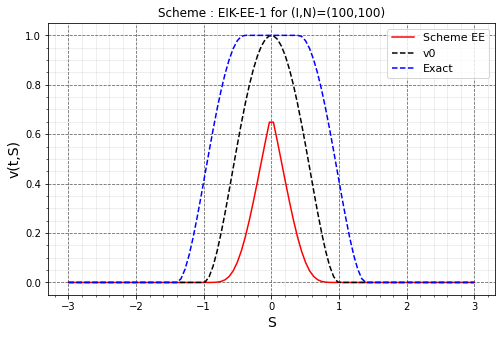

In [48]:
plot_EE(c=1.0, T=0.4, Smin=-3, Smax=3, I=100, N=100, v0_init="v0_2", titles="Scheme : EIK-EE-1 for (I,N)=(100,100)")

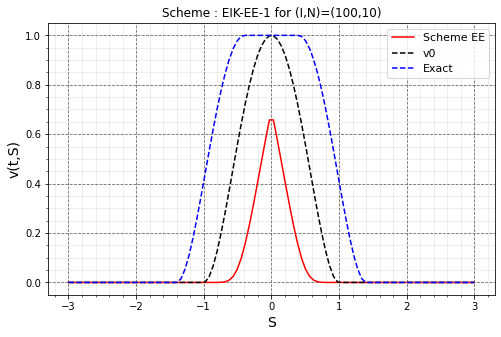

In [49]:
plot_EE(c=1.0, T=0.4, Smin=-3, Smax=3, I=100, N=10, v0_init="v0_2", titles="Scheme : EIK-EE-1 for (I,N)=(100,10)")

In [86]:
def create_table(s_barre, c, T, Smin, Smax, I_list, N_list):
    
    def order_alpha_time(err1, err2, N1, N2):
        delta_t1 = T/N1
        delta_t2 = T/N2
        return np.log(abs(err1/err2))/np.log(abs(delta_t1/delta_t2))
    
    def order_alpha_space(err1, err2, I1, I2):
        h1 = (Smax - Smin)/(I1 + 1)
        h2 = (Smax - Smin)/(I2 + 1)
        return np.log(abs(err1/err2))/np.log(abs(h1/h2))
    
    def v0(x):
        res = -(np.maximum(1 - abs(x)**2, 0))**2
        return res
    
    def exact_solution(c, t, x):
        if (x <= -c*t):
            return v0(x + c*t)
        elif (x >= c*t):
            return v0(x - c*t)
        else:
            return v0(0)
    
    # Création du Dataframe :
    table = pd.DataFrame(data=None, index=None, columns=['I', 'N', 'U(s)', 'error'])

    # Mise à jour des colonnes et choix de l'index :
    table.loc[:,'I'] = I_list
    table.loc[:,'N'] = N_list
    table.set_index('I')
    
    # Computation of the differents approxitions and tcpu:
    tcpu_list = []
    U_s_barre_list = []
    for I, N in zip(I_list, N_list):
        t0 = time.time()
        u = U_s_barre_EE(s_barre, c, T, Smin, Smax, I, N) 
        t1 = time.time()
        U_s_barre_list.append(u)
        tcpu_list.append(t1-t0)
        

    # remplissage du dataframe :
    table.loc[:,'U(s)'] = U_s_barre_list
    
    # calcul de l'erreur :
    table.loc[:,'error'] = table.loc[:,'U(s)'] - exact_solution(c, T, s_barre)
    
    # calcul de l'ordre alpha_k :
    order_alpha_k_time = [order_alpha_time(table["error"].loc[i], table["error"].loc[i+1], N_list[i], N_list[i+1]) for i in range(len(N_list)-1)]
    order_alpha_k_space = [order_alpha_space(table["error"].loc[i], table["error"].loc[i+1], I_list[i], I_list[i+1]) for i in range(len(I_list)-1)]
    for i in range(max(len(order_alpha_k_time), len(order_alpha_k_time))):
        table.at[i+1, "order alpha time"] = order_alpha_k_time[i]
        table.at[i+1, "order alpha space"] = order_alpha_k_space[i]
       
    # temps d'éxécution :
    table.loc[:,'tcpu'] = tcpu_list
        
        
    return table

In [87]:
I_list1 = [int(10*(2**k)) for k in range(6)]
N_list1 = I_list1
create_table(s_barre=1.5, c=1.0, T=1, Smin=-3, Smax=3, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,10,-0.458256,0.104244,NaN,NaN,0.015404
1,20,20,-0.499857,0.062643,0.734728,0.787587,0.014808
2,40,40,-0.521524,0.040976,0.612397,0.634454,0.020465
3,80,80,-0.537191,0.025309,0.695102,0.707628,0.053030
4,160,160,-0.548287,0.014213,0.832446,0.839949,0.238185
5,320,320,-0.555030,0.007470,0.927964,0.932146,1.056560


## 1.2 Improving the order of consistency

In [65]:
def Euler_EE_not_working(c, T, Smin, Smax, I, N):
    
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(1, (I+1))      
    dt = T/N
    
    def vleft(t):
        return 0.0
    
    def vright(t):
        return 0.0
    
    # A'
    def get_A(): 
        A = np.zeros((I,I))
        for i in range(0, I-1):
            A[i, i+1] = 1/(2*h)
        for i in range(1, I):
            A[i, i-1] = -1/(2*h)
        
        return A
    
    
    # q'
    def get_Q(t):
        Q = np.zeros((I,1))
        Q[0] = (1/(2*h)) * vleft(t)
        Q[I-1] = (1/(2*h)) * vright(t) 
        return Q
        
    def v0(x):
        res = -(np.maximum(1 - abs(x)**2, 0))**2
        return res.reshape(I,1)
    
    #init
    U = v0(s)
    Id = np.eye(I)
    
    # main loop 
    for n in range(0, N):
        t = n*dt 
        U = U - dt*c*np.absolute(get_A()@U + get_Q(t))
        
    U = np.insert(U, 0, vleft(T))
    U = np.insert(U, U.size, vright(T))

    return U

In [68]:
def plot_EE_not_working(c, T, Smin, Smax, I, N, titles="Euler EE"):
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(0, (I+2))
    
    def v0(x):
        res = -(np.maximum(1 - x**2, 0))**2
        return res
    
    def exact_solution(c, t, x):
        if (x <= -c*t):
            return v0(x + c*t)
        elif (x >= c*t):
            return v0(x - c*t)
        else:
            return v0(0)
    
    vect_sol_exact = [exact_solution(c, T, x) for x in list(s)]
    
    U = Euler_EE_not_working(c, T, Smin, Smax, I, N)
    # Plot the data
    plt.figure(figsize=(8,5))
    plt.plot(s, U, "r", label="Scheme EE")
    plt.plot(s, vect_sol_exact, "b", ls="--", label="Exact")
    plt.plot(s, v0(s), "black", ls="--", label="v0")

    # Show the major grid lines with dark grey lines
    plt.grid(b=True, which='major', color='#666666', linestyle='--')

    # Show the minor grid lines with very faint and almost transparent grey lines
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
    plt.title(titles)
    plt.xlabel("S", fontsize=14)
    plt.ylabel("v(t,S)", fontsize=14)
    plt.legend(fontsize=11)

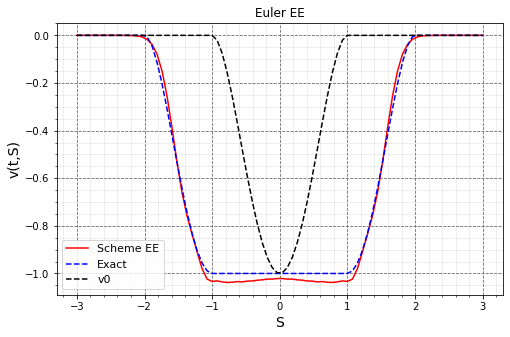

In [69]:
plot_EE_not_working(c=1.0, T=1, Smin=-3, Smax=3, I=80, N=80)

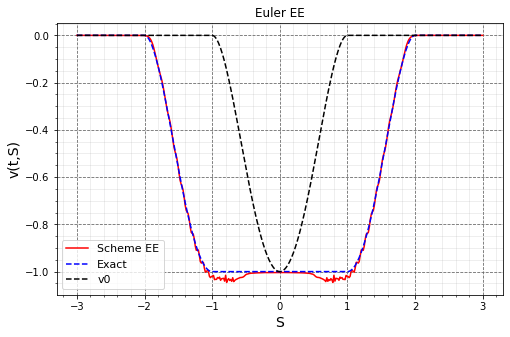

In [70]:
plot_EE_not_working(c=1.0, T=1, Smin=-3, Smax=3, I=400, N=400)

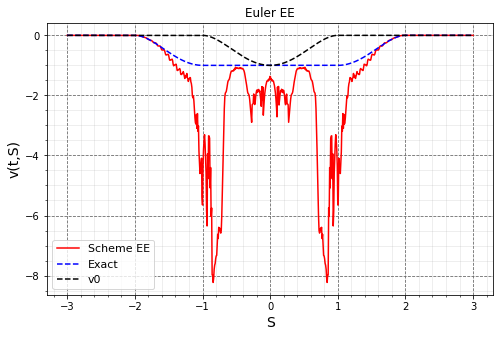

In [71]:
plot_EE_not_working(c=1.0, T=1, Smin=-3, Smax=3, I=800, N=800)

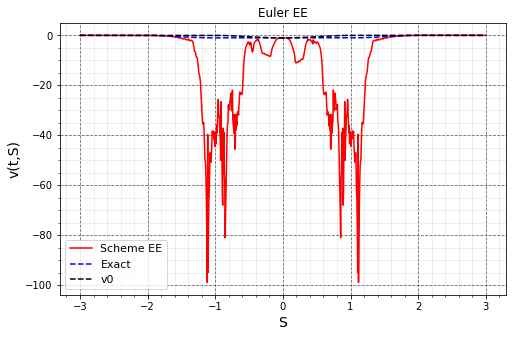

In [73]:
plot_EE_not_working(c=1.0, T=1, Smin=-3, Smax=3, I=1000, N=1000)

Le schéma explose pour $I=800=800$

### Modified scheme 

In [74]:
def Euler_EE_modified(c, T, Smin, Smax, I, N):
    
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(1, (I+1))      
    dt = T/N
    
    def vleft(t):
        return 0.0
    
    def vright(t):
        return 0.0
    
    # D_ tilde
    def get_D1(): 
        D = np.zeros((I,I))
        for i in range(0, I):
            D[i, i] = 3/(2*h)
        for i in range(1, I):
            D[i, i-1] = -4/(2*h)
        for i in range(2, I):
            D[i, i-2] = 1/(2*h)
        
        return D
    
    # D+ tilde
    def get_D2(): 
        D = np.zeros((I,I))
        for i in range(0, I):
            D[i, i] = -3/(2*h)
        for i in range(0, I-1):
            D[i, i+1] = 4/(2*h)
        for i in range(0, I-2):
            D[i, i+2] = -1/(2*h)
        
        return D
    
    
    # q_ tilde
    def get_Q1(t):
        Q = np.zeros((I,1))
        Q[0] = (-4/(2*h))*vleft(t)
        Q[1] = (1/(2*h))*vleft(t)
        
        return Q
    
    # q+ tilde
    def get_Q2(t):
        Q = np.zeros((I,1))
        Q[I-1] = (4/(2*h))*vright(t)
        Q[I-2] = (-1/(2*h))*vright(t)
        
        return Q
        
    def v0(x):
        res = -(np.maximum(1 - abs(x)**2, 0))**2
        return res.reshape(I,1)
    
    #init
    U = v0(s)
    Id = np.eye(I)
    
    # main loop 
    for n in range(0, N):
        t = n*dt 
        U = U - dt*np.maximum(c*get_D1()@U + get_Q1(t), -c*(get_D2()@U + get_Q2(t)))
        
    U = np.insert(U, 0, vleft(T))
    U = np.insert(U, U.size, vright(T))

    return U

In [75]:
def plot_EE_modified(c, T, Smin, Smax, I, N, titles="Euler EE"):
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(0, (I+2))
    
    def v0(x):
        res = -(np.maximum(1 - x**2, 0))**2
        return res
    
    def exact_solution(c, t, x):
        if (x <= -c*t):
            return v0(x + c*t)
        elif (x >= c*t):
            return v0(x - c*t)
        else:
            return v0(0)
    
    vect_sol_exact = [exact_solution(c, T, x) for x in list(s)]
    
    U = Euler_EE_modified(c, T, Smin, Smax, I, N)
    # Plot the data
    plt.figure(figsize=(8,5))
    plt.plot(s, U, "r", label="Scheme EE")
    plt.plot(s, vect_sol_exact, "b", ls="--", label="Exact")
    plt.plot(s, v0(s), "black", ls="--", label="v0")

    # Show the major grid lines with dark grey lines
    plt.grid(b=True, which='major', color='#666666', linestyle='--')

    # Show the minor grid lines with very faint and almost transparent grey lines
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
    plt.title(titles)
    plt.xlabel("S", fontsize=14)
    plt.ylabel("Prix", fontsize=14)
    plt.legend(fontsize=11)

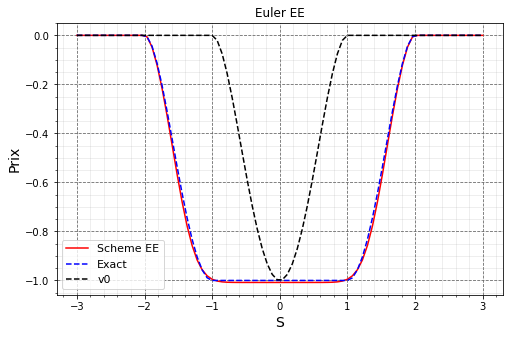

In [76]:
plot_EE_modified(c=1.0, T=1, Smin=-3, Smax=3, I=80, N=80)

Une première approche sur la performance de ce schéma par rapport au précédent : à l'aide du graphique, nous pouvons d'ores et déjà remarquer que le schéma coincide parfaitement avec la solution exacte de l'EDP.
Et donc que l'erreur de consistence devrait normalement être diminué. Confirmons cela à l'aide du tableau des erreurs :

In [77]:
def U_s_barre_EE_modified(s_barre, c, T, Smin, Smax, I, N):
    h = (Smax - Smin)/(I+1)
    S_vect = Smin + h*np.arange(0, (I+2)) 
    U_vect = Euler_EE_modified(c, T, Smin, Smax, I, N)
    
    s_i = 0
    s_i_plus_1 = 0
    u_i = 0
    u_i_plus_1 = 0
    
    for i in range(S_vect.size):     
        if s_barre < S_vect[i]:
            s_i = S_vect[i-1]
            s_i_plus_1 = S_vect[i]
            u_i = U_vect[i-1]
            u_i_plus_1 = U_vect[i]   
            break
    
    u_s_barre = ((s_i_plus_1 - s_barre)/h)*u_i + ((s_barre - s_i)/h)*u_i_plus_1
    
    return u_s_barre

In [80]:
def create_table_modified(s_barre, c, T, Smin, Smax, I_list, N_list):
    
    def order_alpha_time(err1, err2, N1, N2):
        delta_t1 = T/N1
        delta_t2 = T/N2
        return np.log(abs(err1/err2))/np.log(abs(delta_t1/delta_t2))
    
    def order_alpha_space(err1, err2, I1, I2):
        h1 = (Smax - Smin)/(I1 + 1)
        h2 = (Smax - Smin)/(I2 + 1)
        return np.log(abs(err1/err2))/np.log(abs(h1/h2))
    
    def v0(x):
        res = -(np.maximum(1 - abs(x)**2, 0))**2
        return res
    
    def exact_solution(c, t, x):
        if (x <= -c*t):
            return v0(x + c*t)
        elif (x >= c*t):
            return v0(x - c*t)
        else:
            return v0(0)
    
    # Création du Dataframe :
    table = pd.DataFrame(data=None, index=None, columns=['I', 'N', 'U(s)', 'error'])

    # Mise à jour des colonnes et choix de l'index :
    table.loc[:,'I'] = I_list
    table.loc[:,'N'] = N_list
    table.set_index('I')
    
    # Computation of the differents approxitions and tcpu:
    tcpu_list = []
    U_s_barre_list = []
    for I, N in zip(I_list, N_list):
        t0 = time.time()
        u = U_s_barre_EE_modified(s_barre, c, T, Smin, Smax, I, N) 
        t1 = time.time()
        U_s_barre_list.append(u)
        tcpu_list.append(t1-t0)
        

    # remplissage du dataframe :
    table.loc[:,'U(s)'] = U_s_barre_list
    
    # calcul de l'erreur :
    table.loc[:,'error'] = table.loc[:,'U(s)'] - exact_solution(c, T, s_barre)
    
    # calcul de l'ordre alpha_k :
    order_alpha_k_time = [order_alpha_time(table["error"].loc[i], table["error"].loc[i+1], N_list[i], N_list[i+1]) for i in range(len(N_list)-1)]
    order_alpha_k_space = [order_alpha_space(table["error"].loc[i], table["error"].loc[i+1], I_list[i], I_list[i+1]) for i in range(len(I_list)-1)]
    for i in range(max(len(order_alpha_k_time), len(order_alpha_k_time))):
        table.at[i+1, "order alpha time"] = order_alpha_k_time[i]
        table.at[i+1, "order alpha space"] = order_alpha_k_space[i]
       
    # temps d'éxécution :
    table.loc[:,'tcpu'] = tcpu_list
        
        
    return table

In [89]:
I_list1 = [int(10*(2**k)) for k in range(7)]
N_list1 = I_list1
create_table(s_barre=1.5, c=1.0, T=1, Smin=-3, Smax=3, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,10,-0.458256,0.104244,NaN,NaN,0.008902
1,20,20,-0.499857,0.062643,0.734728,0.787587,0.015654
2,40,40,-0.521524,0.040976,0.612397,0.634454,0.027723
3,80,80,-0.537191,0.025309,0.695102,0.707628,0.065687
4,160,160,-0.548287,0.014213,0.832446,0.839949,0.239826
5,320,320,-0.555030,0.007470,0.927964,0.932146,0.904784
6,640,640,-0.558679,0.003821,0.967137,0.969317,5.711658


In [88]:
I_list1 = [int(10*(2**k)) for k in range(7)]
N_list1 = I_list1
create_table_modified(s_barre=1.5, c=1.0, T=1, Smin=-3, Smax=3, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,10,-0.698457,-0.135957,NaN,NaN,0.000502
1,20,20,-0.653443,-0.090943,0.580114,0.621849,0.003444
2,40,40,-0.628261,-0.065761,0.467731,0.484578,0.005596
3,80,80,-0.594177,-0.031677,1.053781,1.072771,0.014162
4,160,160,-0.569726,-0.007226,2.132274,2.151493,0.065494
5,320,320,-0.565275,-0.002775,1.380872,1.387096,0.274239
6,640,640,-0.563614,-0.001114,1.316906,1.319874,0.862152


Nous observons bien une erreur de plus en plus faible pour de grandes valeurs de I et N. De plus on remarque que le schéma n'explose pas contrairement au schéma de la première question.

### RK2 variant

In [90]:
def RK2(c, T, Smin, Smax, I, N):
    
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(1, (I+1))      
    dt = T/N
    
    def vleft(t):
        return 0.0
    
    def vright(t):
        return 0.0
    
    # D_ tilde
    def get_D1(): 
        D = np.zeros((I,I))
        for i in range(0, I):
            D[i, i] = 3/(2*h)
        for i in range(1, I):
            D[i, i-1] = -4/(2*h)
        for i in range(2, I):
            D[i, i-2] = 1/(2*h)
        
        return D
    
    # D+ tilde
    def get_D2(): 
        D = np.zeros((I,I))
        for i in range(0, I):
            D[i, i] = -3/(2*h)
        for i in range(0, I-1):
            D[i, i+1] = 4/(2*h)
        for i in range(0, I-2):
            D[i, i+2] = -1/(2*h)
        
        return D
    
    
    # q_ tilde
    def get_Q1(t):
        Q = np.zeros((I,1))
        Q[0] = (-4/(2*h))*vleft(t)
        Q[1] = (1/(2*h))*vleft(t)
        
        return Q
    
    # q+ tilde
    def get_Q2(t):
        Q = np.zeros((I,1))
        Q[I-1] = (4/(2*h))*vright(t)
        Q[I-2] = (-1/(2*h))*vright(t)
        
        return Q
        
    def v0(x):
        res = -(np.maximum(1 - abs(x)**2, 0))**2
        return res.reshape(I,1)
    
    def S_one(t, U):
        """
            U : matrix
        """
        return U - dt*np.maximum(c*get_D1()@U + get_Q1(t), -c*(get_D2()@U + get_Q2(t)))
    
    #init
    U = v0(s)
    Id = np.eye(I)
    
    # main loop 
    for n in range(0, N):
        t = n*dt 
        U = 0.5*(U + S_one(t, S_one(t, U)))
        
    U = np.insert(U, 0, vleft(T))
    U = np.insert(U, U.size, vright(T))

    return U

In [92]:
def plot_RK2(c, T, Smin, Smax, I, N, titles="Euler EE"):
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(0, (I+2))
    
    def v0(x):
        res = -(np.maximum(1 - x**2, 0))**2
        return res
    
    def exact_solution(c, t, x):
        if (x <= -c*t):
            return v0(x + c*t)
        elif (x >= c*t):
            return v0(x - c*t)
        else:
            return v0(0)
    
    vect_sol_exact = [exact_solution(c, T, x) for x in list(s)]
    
    U = RK2(c, T, Smin, Smax, I, N)
    # Plot the data
    plt.figure(figsize=(8,5))
    plt.plot(s, U, "r", label="Scheme EE")
    plt.plot(s, vect_sol_exact, "b", ls="--", label="Exact")
    plt.plot(s, v0(s), "black", ls="--", label="v0")

    # Show the major grid lines with dark grey lines
    plt.grid(b=True, which='major', color='#666666', linestyle='--')

    # Show the minor grid lines with very faint and almost transparent grey lines
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
    plt.title(titles)
    plt.xlabel("S", fontsize=14)
    plt.ylabel("Prix", fontsize=14)
    plt.legend(fontsize=11)

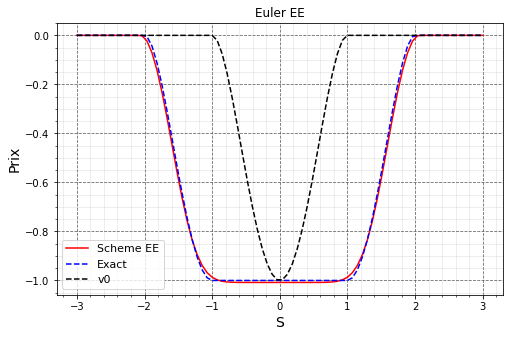

In [93]:
plot_RK2(c=1.0, T=1, Smin=-3, Smax=3, I=80, N=80)

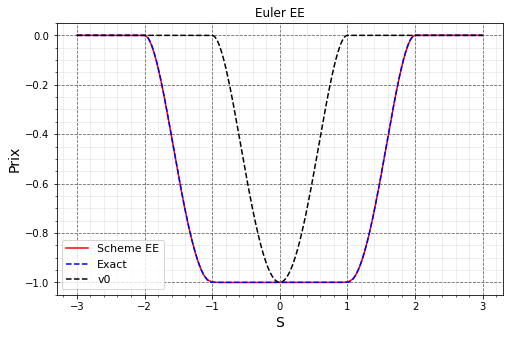

In [94]:
plot_RK2(c=1.0, T=1, Smin=-3, Smax=3, I=400, N=400)

In [95]:
def U_s_barre_RK2(s_barre, c, T, Smin, Smax, I, N):
    h = (Smax - Smin)/(I+1)
    S_vect = Smin + h*np.arange(0, (I+2)) 
    U_vect = RK2(c, T, Smin, Smax, I, N)
    
    s_i = 0
    s_i_plus_1 = 0
    u_i = 0
    u_i_plus_1 = 0
    
    for i in range(S_vect.size):     
        if s_barre < S_vect[i]:
            s_i = S_vect[i-1]
            s_i_plus_1 = S_vect[i]
            u_i = U_vect[i-1]
            u_i_plus_1 = U_vect[i]   
            break
    
    u_s_barre = ((s_i_plus_1 - s_barre)/h)*u_i + ((s_barre - s_i)/h)*u_i_plus_1
    
    return u_s_barre

In [96]:
def create_table_RK2(s_barre, c, T, Smin, Smax, I_list, N_list):
    
    def order_alpha_time(err1, err2, N1, N2):
        delta_t1 = T/N1
        delta_t2 = T/N2
        return np.log(abs(err1/err2))/np.log(abs(delta_t1/delta_t2))
    
    def order_alpha_space(err1, err2, I1, I2):
        h1 = (Smax - Smin)/(I1 + 1)
        h2 = (Smax - Smin)/(I2 + 1)
        return np.log(abs(err1/err2))/np.log(abs(h1/h2))
    
    def v0(x):
        res = -(np.maximum(1 - abs(x)**2, 0))**2
        return res
    
    def exact_solution(c, t, x):
        if (x <= -c*t):
            return v0(x + c*t)
        elif (x >= c*t):
            return v0(x - c*t)
        else:
            return v0(0)
    
    # Création du Dataframe :
    table = pd.DataFrame(data=None, index=None, columns=['I', 'N', 'U(s)', 'error'])

    # Mise à jour des colonnes et choix de l'index :
    table.loc[:,'I'] = I_list
    table.loc[:,'N'] = N_list
    table.set_index('I')
    
    # Computation of the differents approxitions and tcpu:
    tcpu_list = []
    U_s_barre_list = []
    for I, N in zip(I_list, N_list):
        t0 = time.time()
        u = U_s_barre_RK2(s_barre, c, T, Smin, Smax, I, N) 
        t1 = time.time()
        U_s_barre_list.append(u)
        tcpu_list.append(t1-t0)
        

    # remplissage du dataframe :
    table.loc[:,'U(s)'] = U_s_barre_list
    
    # calcul de l'erreur :
    table.loc[:,'error'] = table.loc[:,'U(s)'] - exact_solution(c, T, s_barre)
    
    # calcul de l'ordre alpha_k :
    order_alpha_k_time = [order_alpha_time(table["error"].loc[i], table["error"].loc[i+1], N_list[i], N_list[i+1]) for i in range(len(N_list)-1)]
    order_alpha_k_space = [order_alpha_space(table["error"].loc[i], table["error"].loc[i+1], I_list[i], I_list[i+1]) for i in range(len(I_list)-1)]
    for i in range(max(len(order_alpha_k_time), len(order_alpha_k_time))):
        table.at[i+1, "order alpha time"] = order_alpha_k_time[i]
        table.at[i+1, "order alpha space"] = order_alpha_k_space[i]
       
    # temps d'éxécution :
    table.loc[:,'tcpu'] = tcpu_list
        
        
    return table

In [97]:
I_list1 = [int(10*(2**k)) for k in range(7)]
N_list1 = I_list1
create_table_RK2(s_barre=1.5, c=1.0, T=1, Smin=-3, Smax=3, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,10,-0.662104,-0.099604,NaN,NaN,0.000814
1,20,20,-0.622980,-0.060480,0.719730,0.771510,0.004465
2,40,40,-0.604358,-0.041858,0.530955,0.550079,0.008472
3,80,80,-0.584620,-0.022120,0.920183,0.936765,0.021941
4,160,160,-0.567385,-0.004885,2.178948,2.198588,0.113173
5,320,320,-0.563836,-0.001336,1.870059,1.878488,0.429523
6,640,640,-0.562842,-0.000342,1.965302,1.969732,1.870528


Grâce au tableau précédent nous obtenons un ordre 2 pour la variable d'espace et la variable de temps également.
Ainsi le schéma RK2 du dessus est bien un schéma d'ordre (2,2). 

#### VERIFIER LA CONDITION CFL AVEC LA MATRICE D AMPLIFICATION

# IE scheme

#### Implement a "semi-smooth" Newton's method 

We now want to apply a Newton type algorithm for solving $F(x)=0$ with:

$$
F(x):=\max (B x-b, Cx-c) \quad \text{for} \quad x \in \mathbb{R}^I
$$

We consider the following algorithm: 

- iterate over $k \geq 0$ (for a given $x^{0}$ starting point of $\mathbb{R}^{I}$, to be choosen)
$$
x^{k+1}=x^{k}-F^{\prime}\left(x^{k}\right)^{-1} F\left(x^{k}\right)
$$
until $F\left(x^{k}\right)=0$ (or, that $x^{k+1}=x^{k}$ i.e until convergence). 

In this iteration, $F(x^k):=\max (B x^k - b, Cx^k - c)$ and we will take the following definition for $F^{\prime}\left(x^{k}\right)$ (row by row derivative):

$$
F^{\prime}\left(x^{k}\right)_{i, j}:= \begin{cases}B_{i, j} & \text { if }\left(B x^{k}-b\right)_{i} \geq \left(Cx^{k}-c\right)_{i} \\ C_{i, j} & \text { otherwise }\end{cases}
$$

(Note the specific choice $F^{\prime}\left(x^{k}\right)_{i, j}=B_{i, j}$ even in the case when $\left(B x^{k}-b\right)_{i}=\left(Cx^{k}-c\right)_{i}$. The other choice $F^{\prime}\left(x^{k}\right)_{i, j}=C_{i, j}$ if $\left(B x^{k}-b\right)_{i}=\left(Cx^{k}-c\right)_{i}$ works also but may be less efficient : i.e more iterations might be needed).

In [194]:
def Euler_EI(c, T, Smin, Smax, I, N, v0_init="v0_1", eta=1e-5, kmax=100, show_iter=False):
    
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(1, (I+1))      
    dt = T/N
    
    def vleft(t):
        return 0.0
    
    def vright(t):
        return 0.0
    
    # the matrix A_
    def get_A1(): 
        A = np.zeros((I,I))
        for i in range(0, I):
            A[i, i] = c/h
        for i in range(1, I):
            A[i, i-1] = -c/h
        
        return A
    
    # the matrix A+
    def get_A2(): 
        A = np.zeros((I,I))
        for i in range(0, I):
            A[i, i] = c/h
        for i in range(0, I-1):
            A[i, i+1] = -c/h
        
        return A
    
    
    # the vector function q_
    def get_Q1(t):
        Q = np.zeros((I,1))
        Q[0] = -(c/h)*vleft(t)
        
        return Q
    
    # the vector function q+
    def get_Q2(t):
        Q = np.zeros((I,1))
        Q[I-1] = (c/h)*vright(t)
        
        return Q
        
    def v0(x):
        if (v0_init == "v0_1"):
            return (-(np.maximum(1 - abs(x)**2, 0))**2).reshape(I,1)
        elif (v0_init == "v0_2"):
            return ((np.maximum(1 - abs(x)**2, 0))**2).reshape(I,1)
        else:
            print("Function v0 is not well defined!")
            
    # initialization
    U = v0(s)
    Id = np.eye(I)
    
    # main loop 
    for n in range(0, N):
        t = n*dt 
        t1 = (n+1)*dt
        B1 = Id + dt*get_A1()
        B2 = Id + dt*get_A2()
        b1 = U - dt*get_Q1(t1)
        b2 = U - dt*get_Q2(t1)

        x = U.copy()
        xold = np.zeros((I,1))
        k = 0
        err = 1 # we start with an error >> 1e-5, so we can choose error=1
        
        while (err > eta and k < kmax):
            xold = x.copy()
            F = np.maximum(B1 @ x - b1, B2 @ x - b2)
            Fp = B2.copy()
            i, j = np.where((B1 @ x - b1) >= (B2 @ x - b2))
            Fp[i,:] = B1[i,:]
            x = x - lng.solve(Fp, F)
                
            err = lng.norm(x - xold, np.inf)
            if (show_iter):
                print("k=%s, err=%10.8f" %(k, err))
            k = k+1
        U = x
        
    U = np.insert(U, 0, vleft(T))
    U = np.insert(U, U.size, vright(T))

    return U

In [195]:
Euler_EI(c=1.0, T=1, Smin=-3, Smax=3, I=20, N=20, v0_init="v0_1", show_iter=False)

array([ 0.        , -0.04069477, -0.0835102 , -0.15842857, -0.27528562,
       -0.43393525, -0.61534973, -0.78198696, -0.89628841, -0.94794756,
       -0.95960017, -0.95960017, -0.94794756, -0.89628841, -0.78198696,
       -0.61534973, -0.43393525, -0.27528562, -0.15842857, -0.0835102 ,
       -0.04069479,  0.        ])

In [196]:
Euler_EE(c=1.0, T=1, Smin=-3, Smax=3, I=20, N=20)

array([ 0.        , -0.01885399, -0.0537854 , -0.12936121, -0.26223594,
       -0.44882719, -0.65294513, -0.82050946, -0.91770752, -0.9533447 ,
       -0.95960017, -0.95960017, -0.9533447 , -0.91770752, -0.82050946,
       -0.65294513, -0.44882719, -0.26223594, -0.12936121, -0.0537854 ,
       -0.01885399,  0.        ])

In [210]:
def plot_EI(c, T, Smin, Smax, I, N, titles="Euler EI", v0_init="v0_1", eta=1e-5, kmax=100, show_iter=False):
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(0, (I+2))
    
    def v0(x):
        res = -(np.maximum(1 - x**2, 0))**2
        return res
    
    def exact_solution(c, t, x):
        if (x <= -c*t):
            return v0(x + c*t)
        elif (x >= c*t):
            return v0(x - c*t)
        else:
            return v0(0)
    
    vect_sol_exact = [exact_solution(c, T, x) for x in list(s)]
    
    U = Euler_EI(c, T, Smin, Smax, I, N, v0_init, eta, kmax, show_iter)
    # Plot the data
    plt.figure(figsize=(8,5))
    plt.plot(s, U, "r", label="Scheme EI")
    plt.plot(s, vect_sol_exact, "b", ls="--", label="Exact")
    plt.plot(s, v0(s), "black", ls="--", label="v0")

    # Show the major grid lines with dark grey lines
    plt.grid(b=True, which='major', color='#666666', linestyle='--')

    # Show the minor grid lines with very faint and almost transparent grey lines
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
    plt.title(titles)
    plt.xlabel("S", fontsize=14)
    plt.ylabel("v(t, S)", fontsize=14)
    plt.legend(fontsize=11)

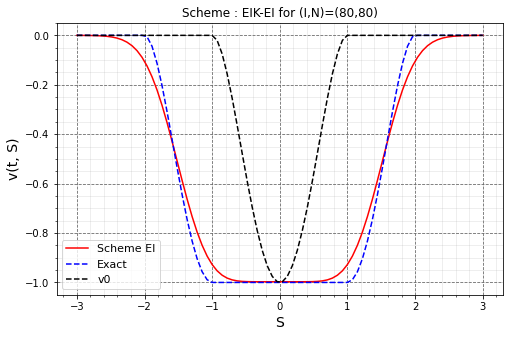

In [213]:
plot_EI(c=1.0, T=1.0, Smin=-3, Smax=3, I=80, N=80, titles="Scheme : EIK-EI for (I,N)=(80,80)")

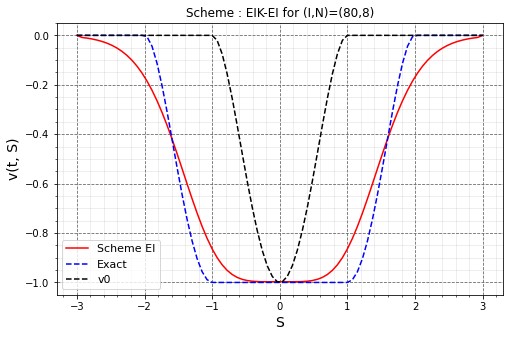

In [214]:
plot_EI(c=1.0, T=1.0, Smin=-3, Smax=3, I=80, N=8, titles="Scheme : EIK-EI for (I,N)=(80,8)")

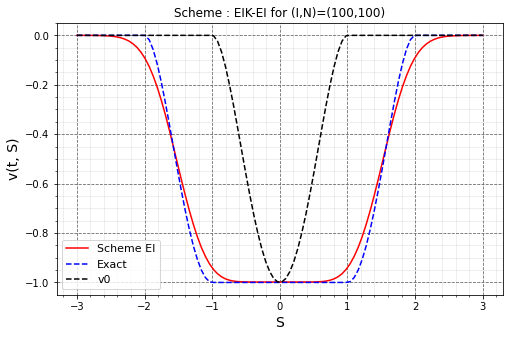

In [218]:
plot_EI(c=1.0, T=1.0, Smin=-3, Smax=3, I=100, N=100, titles="Scheme : EIK-EI for (I,N)=(100,100)")

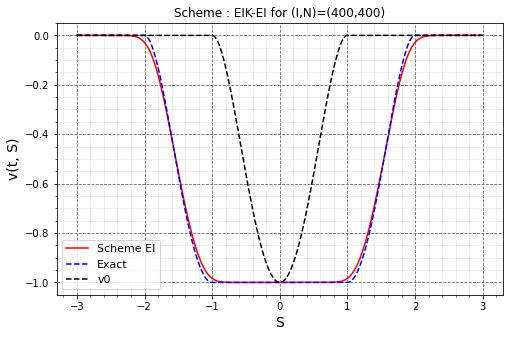

In [219]:
plot_EI(c=1.0, T=1.0, Smin=-3, Smax=3, I=400, N=400, titles="Scheme : EIK-EI for (I,N)=(400,400)")

In [206]:
def U_s_barre_EI(s_barre, c, T, Smin, Smax, I, N, v0_init="v0_1", eta=1e-5, kmax=100, show_iter=False):
    h = (Smax - Smin)/(I+1)
    S_vect = Smin + h*np.arange(0, (I+2)) 
    U_vect = Euler_EI(c, T, Smin, Smax, I, N, v0_init, eta, kmax, show_iter)
    
    s_i = 0
    s_i_plus_1 = 0
    u_i = 0
    u_i_plus_1 = 0
    
    for i in range(S_vect.size):     
        if s_barre < S_vect[i]:
            s_i = S_vect[i-1]
            s_i_plus_1 = S_vect[i]
            u_i = U_vect[i-1]
            u_i_plus_1 = U_vect[i]   
            break
    
    u_s_barre = ((s_i_plus_1 - s_barre)/h)*u_i + ((s_barre - s_i)/h)*u_i_plus_1
    
    return u_s_barre

In [299]:
def create_table_EI(s_barre, c, T, Smin, Smax, I_list, N_list, v0_init="v0_1", eta=1e-5, kmax=100, show_iter=False):
    
    def order_alpha_time(err1, err2, N1, N2):
        delta_t1 = T/N1
        delta_t2 = T/N2
        return np.log(abs(err1/err2))/np.log(abs(delta_t1/delta_t2))
    
    def order_alpha_space(err1, err2, I1, I2):
        h1 = (Smax - Smin)/(I1 + 1)
        h2 = (Smax - Smin)/(I2 + 1)
        return np.log(abs(err1/err2))/np.log(abs(h1/h2))
    
    def v0(x):
        res = -(np.maximum(1 - abs(x)**2, 0))**2
        return res
    
    def exact_solution(c, t, x):
        if (x <= -c*t):
            return v0(x + c*t)
        elif (x >= c*t):
            return v0(x - c*t)
        else:
            return v0(0)
    
    # Création du Dataframe :
    table = pd.DataFrame(data=None, index=None, columns=['I', 'N', 'U(s)', 'error'])

    # Mise à jour des colonnes et choix de l'index :
    table.loc[:,'I'] = I_list
    table.loc[:,'N'] = N_list
    table.set_index('I')
    
    # Computation of the differents approxitions and tcpu:
    tcpu_list = []
    U_s_barre_list = []
    for I, N in zip(I_list, N_list):
        t0 = time.time()
        u = U_s_barre_EI(s_barre, c, T, Smin, Smax, I, N, v0_init, eta, kmax, show_iter)
        t1 = time.time()
        U_s_barre_list.append(u)
        tcpu_list.append(t1-t0)
        

    # remplissage du dataframe :
    table.loc[:,'U(s)'] = U_s_barre_list
    
    # calcul de l'erreur :
    table.loc[:,'error'] = table.loc[:,'U(s)'] - exact_solution(c, T, s_barre)
    
    # calcul de l'ordre alpha_k :
    order_alpha_k_time = [order_alpha_time(table["error"].loc[i], table["error"].loc[i+1], N_list[i], N_list[i+1]) for i in range(len(N_list)-1)]
    order_alpha_k_space = [order_alpha_space(table["error"].loc[i], table["error"].loc[i+1], I_list[i], I_list[i+1]) for i in range(len(I_list)-1)]
    for i in range(max(len(order_alpha_k_time), len(order_alpha_k_time))):
        table.at[i+1, "order alpha time"] = order_alpha_k_time[i]
        table.at[i+1, "order alpha space"] = order_alpha_k_space[i]
       
    # temps d'éxécution :
    table.loc[:,'tcpu'] = tcpu_list
        
        
    return table

In [300]:
I_list1 = [int(10*(2**k)) for k in range(7)]
N_list1 = I_list1
create_table_EI(s_barre=1.5, c=1.0, T=1, Smin=-3, Smax=3, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,10,-0.428825,0.133675,NaN,NaN,0.004313
1,20,20,-0.479289,0.083211,0.683883,0.733083,0.003569
2,40,40,-0.506967,0.055533,0.583441,0.604455,0.009714
3,80,80,-0.527366,0.035134,0.660457,0.672359,0.028744
4,160,160,-0.542404,0.020096,0.805992,0.813257,0.228100
5,320,320,-0.551929,0.010571,0.926808,0.930986,0.770881
6,640,640,-0.557119,0.005381,0.974007,0.976202,12.388723


In [215]:
I_list1 = [int(10*(2**k)) for k in range(7)]
N_list1 = [int(i/10) for i in I_list1]
create_table_EI(s_barre=1.5, c=1.0, T=1, Smin=-3, Smax=3, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,1,-0.349821,0.212679,NaN,NaN,0.159191
1,20,2,-0.419287,0.143213,0.570510,0.611554,0.013164
2,40,4,-0.461938,0.100562,0.510083,0.528455,0.084507
3,80,8,-0.493825,0.068675,0.550226,0.560142,0.012591
4,160,16,-0.519190,0.043310,0.665095,0.671090,0.077032
5,320,32,-0.538097,0.024403,0.827630,0.831360,0.114709
6,640,64,-0.549933,0.012567,0.957431,0.959589,1.610012


In [217]:
I_list1 = [int(10*(2**k)) for k in range(7)]
N_list1 = [int(i/10) for i in I_list1]
create_table(s_barre=1.5, c=1.0, T=1, Smin=-3, Smax=3, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,1,-1.502630e-01,4.122370e-01,NaN,NaN,0.000968
1,20,2,-1.836735e-01,3.788265e-01,0.121937,0.130709,0.001261
2,40,4,-2.899588e-01,2.725412e-01,0.475063,0.492174,0.004820
3,80,8,-1.150614e+00,-5.881142e-01,-1.109622,-1.129618,0.008533
4,160,16,-8.030640e+00,-7.468140e+00,-3.666581,-3.699630,0.024019
5,320,32,-1.448551e+05,-1.448545e+05,-14.243496,-14.307701,0.105657
6,640,64,-1.584771e+13,-1.584771e+13,-26.705094,-26.765288,0.601581


## 1.4 Implicit second order variant

In [341]:
def Euler_EI_variant_second_order(c, T, Smin, Smax, I, N, v0_init="v0_1", eta=1e-5, kmax=100, show_iter=False):
    
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(1, (I+1))      
    dt = T/N
    
    def vleft(t):
        return 0.0
    
    def vright(t):
        return 0.0
        
    def v0(x):
        if (v0_init == "v0_1"):
            return (-(np.maximum(1 - abs(x)**2, 0))**2).reshape(I,1)
        elif (v0_init == "v0_2"):
            return ((np.maximum(1 - abs(x)**2, 0))**2).reshape(I,1)
        else:
            print("Function v0 is not well defined!")
            
    # the matrix A_
    def get_A1(): 
        A = np.zeros((I,I))
        for i in range(0, I):
            A[i, i] = c/h
        for i in range(1, I):
            A[i, i-1] = -c/h
        
        return A
    
    # the matrix A+
    def get_A2(): 
        A = np.zeros((I,I))
        for i in range(0, I):
            A[i, i] = c/h
        for i in range(0, I-1):
            A[i, i+1] = -c/h
        
        return A
    
    
    # the vector function q_
    def get_Q1(t):
        Q = np.zeros((I,1))
        Q[0] = -(c/h)*vleft(t)
        
        return Q
    
    # the vector function q+
    def get_Q2(t):
        Q = np.zeros((I,1))
        Q[I-1] = (c/h)*vright(t)
        
        return Q
    
    
    # the matrix A_ tilde
    def get_A1_(): 
        A = np.zeros((I,I))
        for i in range(0, I):
            A[i, i] = (c*3)/(2*h)
        for i in range(1, I):
            A[i, i-1] = -(c*4)/(2*h)
        for i in range(2, I):
            A[i, i-2] = c/(2*h)

        return A
    
    # the matrix A+ tilde
    def get_A2_(): 
        A = np.zeros((I,I))
        for i in range(0, I):
            A[i, i] = (c*3)/(2*h)
        for i in range(0, I-1):
            A[i, i+1] = -(c*4)/(2*h)
        for i in range(0, I-2):
            A[i, i+2] = c/(2*h)

        return A
    
    # the vector function q_ chapeau
    def get_Q1_(t):
        Q = np.zeros((I,1))
        Q[0] = (-3*c/(2*h))*vleft(t)
        Q[1] = (c/(2*h))*vleft(t)

        return Q

    # the vector function q+ chapeau
    def get_Q2_(t):
        Q = np.zeros((I,1))
        Q[I-1] = (-3*c/(2*h))*vright(t)
        Q[I-2] = (c/(2*h))*vright(t)

        return Q

    
    #init
    U = v0(s)
    Id = np.eye(I)
    
    # main loop 
    for n in range(0, N): 
        t = n*dt 
        t1 = (n+1)*dt
        
        if(n==0) :
            B1 = Id + dt*get_A1()
            B2 = Id + dt*get_A2()
            b1 = U - dt*get_Q1(t1)
            b2 = U - dt*get_Q2(t1)

            x = U.copy()
            xold = np.zeros((I,1))
            k = 0
            err = 1 # we start with an error >> 1e-5, so we can choose error=1

            while (err > eta and k < kmax):
                xold = x.copy()
                F = np.maximum(B1 @ x - b1, B2 @ x - b2)
                Fp = B2.copy()
                i, j = np.where((B1 @ x - b1) >= (B2 @ x - b2))
                Fp[i,:] = B1[i,:]
                x = x - lng.solve(Fp, F)

                err = lng.norm(x - xold, np.inf)
                if (show_iter):
                    print("k=%s, err=%10.8f" %(k, err))
                k = k+1
            U = x.copy()
            U_moins = U.copy()
        
        else:
            # Schema implicite avec un ordre plus élévé pour la dérivé première en temps :
            # Utilisation of the left-sided three points finite difference scheme :

            B1_ = 3*Id + 2*dt*get_A1_()
            B2_ = 3*Id + 2*dt*get_A2_()
            b1_ = 4*U - U_moins - 2*dt*get_Q1_(t1)
            b2_ = 4*U - U_moins - 2*dt*get_Q2_(t1)
            
            x_ = U.copy()
            U_inter = U.copy()
            xold_ = np.zeros((I,1))
            
            k_ = 0
            err_ = 1 # we start with an error >> 1e-5, so we can choose error=1

            while (err_ > eta and k_ < kmax):
                xold_ = x_.copy()
                F = np.maximum(B1_ @ x_ - b1_, B2_ @ x_ - b2_)
                Fp = B2_.copy()
                i, j = np.where((B1_ @ x_ - b1_) >= (B2_ @ x_ - b2_))
                Fp[i,:] = B1_[i,:]
                x_ = x_ - lng.solve(Fp, F)

                err_ = lng.norm(x_ - xold_, np.inf)
                if (show_iter):
                    print("k=%s, err=%10.8f" %(k_, err_))
                k_ = k_+1
            U = x_.copy()
            U_moins = U_inter.copy()

    U = np.insert(U, 0, vleft(T))
    U = np.insert(U, U.size, vright(T))

    return U

In [342]:
def plot_EI_variant_second_order(c, T, Smin, Smax, I, N, titles="Euler EI second order", v0_init="v0_1", eta=1e-5, kmax=100, show_iter=False):
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(0, (I+2))
    
    def v0(x):
        res = -(np.maximum(1 - x**2, 0))**2
        return res
    
    def exact_solution(c, t, x):
        if (x <= -c*t):
            return v0(x + c*t)
        elif (x >= c*t):
            return v0(x - c*t)
        else:
            return v0(0)
    
    vect_sol_exact = [exact_solution(c, T, x) for x in list(s)]
    
    U = Euler_EI_variant_second_order(c, T, Smin, Smax, I, N, v0_init, eta, kmax, show_iter)
    # Plot the data
    plt.figure(figsize=(8,5))
    plt.plot(s, U, "r", label="Scheme EI")
    plt.plot(s, vect_sol_exact, "b", ls="--", label="Exact")
    plt.plot(s, v0(s), "black", ls="--", label="v0")

    # Show the major grid lines with dark grey lines
    plt.grid(b=True, which='major', color='#666666', linestyle='--')

    # Show the minor grid lines with very faint and almost transparent grey lines
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
    plt.title(titles)
    plt.xlabel("S", fontsize=14)
    plt.ylabel("v(t, S)", fontsize=14)
    plt.legend(fontsize=11)

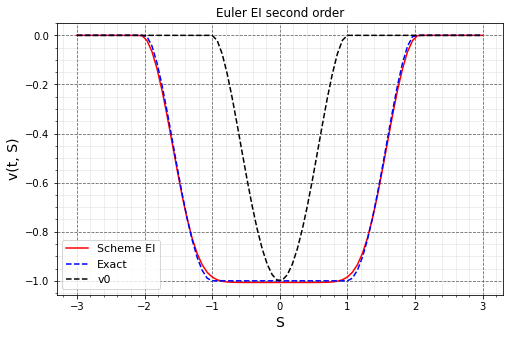

In [343]:
plot_EI_variant_second_order(c=1.0, T=1.0, Smin=-3, Smax=3, I=80, N=80)

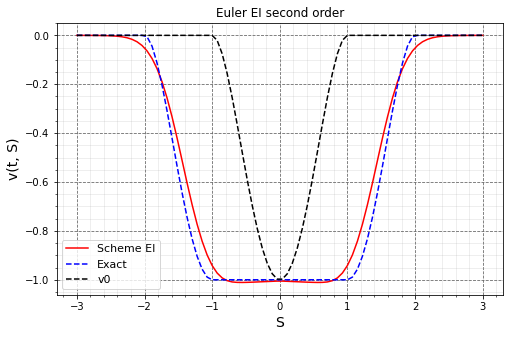

In [344]:
plot_EI_variant_second_order(c=1.0, T=1.0, Smin=-3, Smax=3, I=80, N=8)

Le schéma est stable et n'est pas sujet à une condition CFL, ce qui est commun pour les schémas implicites

In [345]:
def U_s_barre_EI_variant_second_order(s_barre, c, T, Smin, Smax, I, N, v0_init="v0_1", eta=1e-5, kmax=100, show_iter=False):
    h = (Smax - Smin)/(I+1)
    S_vect = Smin + h*np.arange(0, (I+2)) 
    U_vect = Euler_EI_variant_second_order(c, T, Smin, Smax, I, N, v0_init, eta, kmax, show_iter)
    
    s_i = 0
    s_i_plus_1 = 0
    u_i = 0
    u_i_plus_1 = 0
    
    for i in range(S_vect.size):     
        if s_barre < S_vect[i]:
            s_i = S_vect[i-1]
            s_i_plus_1 = S_vect[i]
            u_i = U_vect[i-1]
            u_i_plus_1 = U_vect[i]   
            break
    
    u_s_barre = ((s_i_plus_1 - s_barre)/h)*u_i + ((s_barre - s_i)/h)*u_i_plus_1
    
    return u_s_barre

In [350]:
def create_table_EI_variant_second_order(s_barre, c, T, Smin, Smax, I_list, N_list, v0_init="v0_1", eta=1e-5, kmax=100, show_iter=False):
    
    def order_alpha_time(err1, err2, N1, N2):
        delta_t1 = T/N1
        delta_t2 = T/N2
        return np.log(abs(err1/err2))/np.log(abs(delta_t1/delta_t2))
    
    def order_alpha_space(err1, err2, I1, I2):
        h1 = (Smax - Smin)/(I1 + 1)
        h2 = (Smax - Smin)/(I2 + 1)
        return np.log(abs(err1/err2))/np.log(abs(h1/h2))
    
    def v0(x):
        res = -(np.maximum(1 - abs(x)**2, 0))**2
        return res
    
    def exact_solution(c, t, x):
        if (x <= -c*t):
            return v0(x + c*t)
        elif (x >= c*t):
            return v0(x - c*t)
        else:
            return v0(0)
    
    # Création du Dataframe :
    table = pd.DataFrame(data=None, index=None, columns=['I', 'N', 'U(s)', 'error'])

    # Mise à jour des colonnes et choix de l'index :
    table.loc[:,'I'] = I_list
    table.loc[:,'N'] = N_list
    table.set_index('I')
    
    # Computation of the differents approxitions and tcpu:
    tcpu_list = []
    U_s_barre_list = []
    for I, N in zip(I_list, N_list):
        t0 = time.time()
        u = U_s_barre_EI_variant_second_order(s_barre, c, T, Smin, Smax, I, N, v0_init, eta, kmax, show_iter)
        t1 = time.time()
        U_s_barre_list.append(u)
        tcpu_list.append(t1-t0)
        

    # remplissage du dataframe :
    table.loc[:,'U(s)'] = U_s_barre_list
    
    # calcul de l'erreur :
    table.loc[:,'error'] = table.loc[:,'U(s)'] - exact_solution(c, T, s_barre)
    
    # calcul de l'ordre alpha_k :
    order_alpha_k_time = [order_alpha_time(table["error"].loc[i], table["error"].loc[i+1], N_list[i], N_list[i+1]) for i in range(len(N_list)-1)]
    order_alpha_k_space = [order_alpha_space(table["error"].loc[i], table["error"].loc[i+1], I_list[i], I_list[i+1]) for i in range(len(I_list)-1)]
    for i in range(max(len(order_alpha_k_time), len(order_alpha_k_time))):
        table.at[i+1, "order alpha time"] = order_alpha_k_time[i]
        table.at[i+1, "order alpha space"] = order_alpha_k_space[i]
       
    # temps d'éxécution :
    table.loc[:,'tcpu'] = tcpu_list
        
        
    return table

In [351]:
I_list1 = [int(10*(2**k)) for k in range(7)]
N_list1 = I_list1
create_table_EI_variant_second_order(s_barre=1.5, c=1.0, T=1, Smin=-3, Smax=3, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,10,-0.567192,-0.004692,NaN,NaN,0.003592
1,20,20,-0.576305,-0.013805,-1.556837,-1.668840,0.009694
2,40,40,-0.581508,-0.019008,-0.461420,-0.478039,0.011994
3,80,80,-0.573040,-0.010540,0.850639,0.865968,0.035933
4,160,160,-0.562315,0.000185,5.832797,5.885372,0.194595
5,320,320,-0.561389,0.001111,-2.586452,-2.598111,1.531739
6,640,640,-0.561645,0.000855,0.377052,0.377902,12.123248


In [352]:
I_list1 = [int(10*(2**k)) for k in range(8)]
N_list1 = [int(i/10) for i in I_list1]
create_table_EI_variant_second_order(s_barre=1.5, c=1.0, T=1, Smin=-3, Smax=3, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,1,-0.349821,0.212679,NaN,NaN,0.001002
1,20,2,-0.352066,0.210434,0.015306,0.016407,0.001381
2,40,4,-0.387735,0.174765,0.267958,0.277609,0.004835
3,80,8,-0.442920,0.119580,0.547440,0.557305,0.011134
4,160,16,-0.501268,0.061232,0.965614,0.974318,0.036516
5,320,32,-0.535214,0.027286,1.166132,1.171388,0.214918
6,640,64,-0.549788,0.012712,1.101946,1.104430,2.153185
7,1280,128,-0.556390,0.006110,1.056884,1.058075,11.182449


# 2. A simple uncertain volatility model

## 2.1. Euler Explicit scheme

In [259]:
def Euler_EE_volatility_model(sigma, T, Smin, Smax, I, N):
    
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(1, (I+1))      
    dt = T/N
    
    def vleft(t):
        return 1.0
    
    def vright(t):
        return -1.0
    
    # the matrix D
    def get_D(): 
        D = np.zeros((I,I))
        for i in range(1, I):
            D[i, i-1] = 1/(h**2)
        for i in range(0, I):
            D[i, i] = -2/(h**2)
        for i in range(0, I-1):
            D[i, i+1] = 1/(h**2)
        
        return sparse(D)
    
    
    # the vector function q(t)
    def get_Q(t):
        Q = np.zeros((I,1))
        Q[0] = (1/(h**2))*vleft(t)
        Q[I-1] = (1/(h**2))*vright(t)
        
        return Q
        
    def v0(x):
        res = np.sign(x) * ((np.maximum(1 - abs(x), 0))**4 - 1)
        return res.reshape(I,1)
    
    # initialization
    U = v0(s)
    Id = np.eye(I)
    
    # main loop 
    for n in range(0, N):
        t = n*dt 
        U = U - dt*np.minimum(0, -0.5*(sigma**2)*(get_D()@U + get_Q(t)))
        
    U = np.insert(U, 0, vleft(T))
    U = np.insert(U, U.size, vright(T))

    return U

In [260]:
Euler_EE_volatility_model(sigma=1.0, T=0.5, Smin=-3, Smax=3, I=20, N=20)

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  0.99333611,  0.89337776,
        0.46083439,  0.03968656, -0.32772995, -0.60824725, -0.79547756,
       -0.90477483, -0.9606018 , -0.985559  , -0.99532389, -0.99866813,
       -0.99967968, -1.        ])

In [261]:
def plot_EE_volatility_model(sigma, T, Smin, Smax, I, N, titles="Euler EE volatility model"):
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(0, (I+2))
    
    def v0(x):
        res = np.sign(x) * ((np.maximum(1 - abs(x), 0))**4 - 1)
        return res
    
    
    U = Euler_EE_volatility_model(sigma, T, Smin, Smax, I, N)
    # Plot the data
    plt.figure(figsize=(8,5))
    plt.plot(s, U, "r", label="Scheme EE")
    plt.plot(s, v0(s), "b", ls="--", label="Payoff")

    # Show the major grid lines with dark grey lines
    plt.grid(b=True, which='major', color='#666666', linestyle='--')

    # Show the minor grid lines with very faint and almost transparent grey lines
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
    plt.title(titles)
    plt.xlabel("S", fontsize=14)
    plt.ylabel("v(t, S)", fontsize=14)
    plt.legend(fontsize=11)

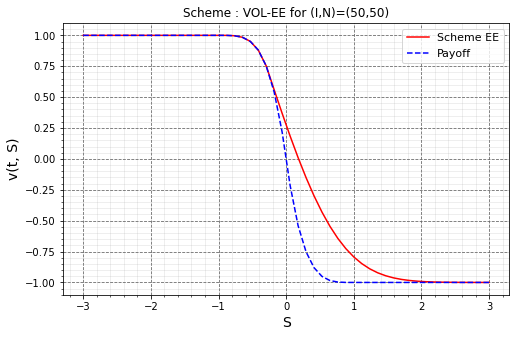

In [353]:
plot_EE_volatility_model(sigma=1.0, T=0.5, Smin=-3, Smax=3, I=50, N=50, titles="Scheme : VOL-EE for (I,N)=(50,50)")

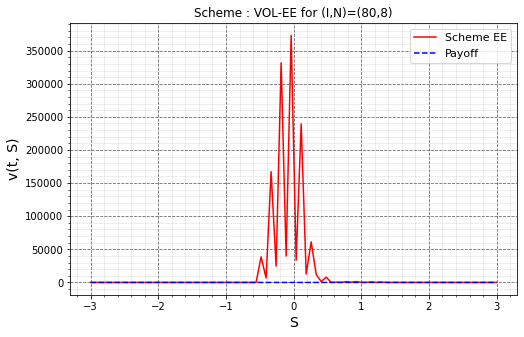

In [354]:
plot_EE_volatility_model(sigma=1.0, T=0.5, Smin=-3, Smax=3, I=80, N=8, titles="Scheme : VOL-EE for (I,N)=(80,8)")

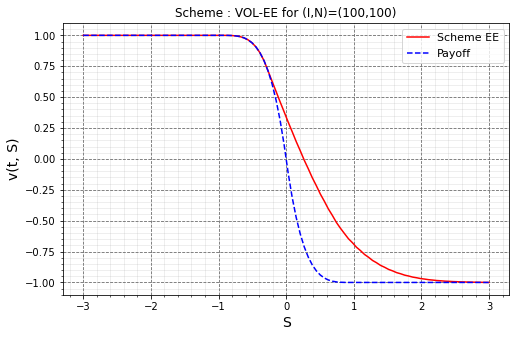

In [355]:
plot_EE_volatility_model(sigma=1.0, T=0.5, Smin=-3, Smax=3, I=100, N=100, titles="Scheme : VOL-EE for (I,N)=(100,100)")

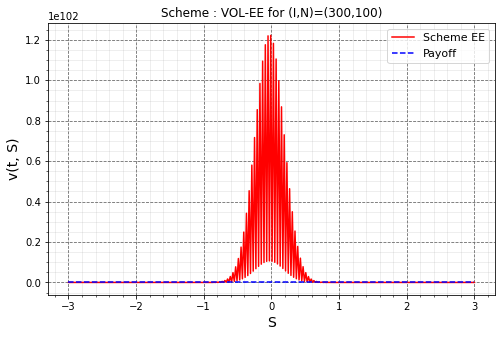

In [373]:
plot_EE_volatility_model(sigma=1.0, T=0.5, Smin=-3, Smax=3, I=300, N=100, titles="Scheme : VOL-EE for (I,N)=(300,100)")

In [265]:
def U_s_barre_EE_volatility_model(s_barre, sigma, T, Smin, Smax, I, N):
    h = (Smax - Smin)/(I+1)
    S_vect = Smin + h*np.arange(0, (I+2)) 
    U_vect = Euler_EE_volatility_model(sigma, T, Smin, Smax, I, N)
    
    s_i = 0
    s_i_plus_1 = 0
    u_i = 0
    u_i_plus_1 = 0
    
    for i in range(S_vect.size):     
        if s_barre < S_vect[i]:
            s_i = S_vect[i-1]
            s_i_plus_1 = S_vect[i]
            u_i = U_vect[i-1]
            u_i_plus_1 = U_vect[i]   
            break
    
    u_s_barre = ((s_i_plus_1 - s_barre)/h)*u_i + ((s_barre - s_i)/h)*u_i_plus_1
    
    return u_s_barre

In [591]:
def create_table_EE_volatility_model(s_barre, sigma, T, Smin, Smax, I_list, N_list):
    
    def order_alpha_time(err1, err2, N1, N2):
        delta_t1 = T/N1
        delta_t2 = T/N2
        return np.log(abs(err1/err2))/np.log(abs(delta_t1/delta_t2))
    
    def order_alpha_space(err1, err2, I1, I2):
        h1 = (Smax - Smin)/(I1 + 1)
        h2 = (Smax - Smin)/(I2 + 1)
        return np.log(abs(err1/err2))/np.log(abs(h1/h2))

    
    # Création du Dataframe :
    table = pd.DataFrame(data=None, index=None, columns=['I', 'N', 'U(s)', 'error'])

    # Mise à jour des colonnes et choix de l'index :
    table.loc[:,'I'] = I_list
    table.loc[:,'N'] = N_list
    table.set_index('I')
    
    # Computation of the differents approxitions and tcpu:
    tcpu_list = []
    U_s_barre_list = []
    for I, N in zip(I_list, N_list):
        t0 = time.time()
        u = U_s_barre_EE_volatility_model(s_barre, sigma, T, Smin, Smax, I, N)
        t1 = time.time()
        U_s_barre_list.append(u)
        tcpu_list.append(t1-t0)
        

    # remplissage du dataframe :
    table.loc[:,'U(s)'] = U_s_barre_list
    
    # calcul de l'erreur :
    exact_sol = -0.3985312700674858
    table.loc[:,'error'] = table.loc[:,'U(s)'] - exact_sol
    
    # calcul de l'ordre alpha_k :
    order_alpha_k_time = [order_alpha_time(table["error"].loc[i], table["error"].loc[i+1], N_list[i], N_list[i+1]) for i in range(len(N_list)-1)]
    order_alpha_k_space = [order_alpha_space(table["error"].loc[i], table["error"].loc[i+1], I_list[i], I_list[i+1]) for i in range(len(I_list)-1)]
    for i in range(max(len(order_alpha_k_time), len(order_alpha_k_time))):
        table.at[i+1, "order alpha time"] = order_alpha_k_time[i]
        table.at[i+1, "order alpha space"] = order_alpha_k_space[i]
       
    # temps d'éxécution :
    table.loc[:,'tcpu'] = tcpu_list
        
        
    return table

In [595]:
I_list1 = [int(10*k) for k in range(1,5)]
N_list1 = I_list1
create_table_EE_volatility_model(s_barre=0.5, sigma=1.0, T=0.5, Smin=-3, Smax=3, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,10,-0.385685,0.012847,NaN,NaN,0.003493
1,20,20,-0.397859,0.000672,4.256817,4.563063,0.010370
2,30,30,-0.402256,-0.003725,-4.223728,-4.397251,0.014163
3,40,40,-0.397910,0.000621,6.226903,6.407244,0.011381


## 2.2 Euler Implicit scheme

In [283]:
def Euler_EI_volatility_model(sigma, T, Smin, Smax, I, N):
    
    eta=1e-5 
    kmax=100 
    show_iter=False
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(1, (I+1))      
    dt = T/N
    
    def vleft(t):
        return 1.0
    
    def vright(t):
        return -1.0
    
    # the matrix A
    def get_A(): 
        A = np.zeros((I,I))
        for i in range(1, I):
            A[i, i-1] = -(sigma**2)/(2 * h**2)
        for i in range(0, I):
            A[i, i] = (sigma**2)/(h**2)
        for i in range(0, I-1):
            A[i, i+1] = -(sigma**2)/(2 * h**2)
        
        return A
    
    
    # the vector function q(t)
    def get_Q(t):
        Q = np.zeros((I,1))
        Q[0] = -(sigma**2)/(2 * h**2) * vleft(t)
        Q[I-1] = -(sigma**2)/(2 * h**2) * vright(t)
        
        return Q
        
    def v0(x):
        res = np.sign(x) * ((np.maximum(1 - abs(x), 0))**4 - 1)
        return res.reshape(I,1)
            
    # initialization
    U = v0(s)
    Id = np.eye(I)
    
    # main loop 
    for n in range(0, N):
        t = n*dt 
        t1 = (n+1)*dt
        B = Id + dt*get_A()
        b = U - dt*get_Q(t1)
        c = U.copy() 

        x = U.copy()
        xold = np.zeros((I,1))
        k = 0
        err = 1 # we start with an error >> 1e-5, so we can choose error=1
        
        while (err > eta and k < kmax):
            xold = x.copy()
            F = np.minimum(B @ x - b, x - c)
            Fp = np.eye(I)
            i, j = np.where(B @ x - b <= x - c)
            Fp[i,:] = B[i,:]
            x = x - lng.solve(Fp, F)
                
            err = lng.norm(x - xold, np.inf)
            if (show_iter):
                print("k=%s, err=%10.8f" %(k, err))
            k = k+1
        U = x
        
    U = np.insert(U, 0, vleft(T))
    U = np.insert(U, U.size, vright(T))

    return U

In [284]:
Euler_EI_volatility_model(sigma=1.0, T=0.5, Smin=-3, Smax=3, I=20, N=20)

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  0.99333611,  0.89337776,
        0.46049057,  0.0293383 , -0.34177537, -0.61854674, -0.79908133,
       -0.90329485, -0.95718561, -0.98244418, -0.99329234, -0.99761396,
       -0.99926415, -1.        ])

In [320]:
def plot_EI_volatility_model(sigma, T, Smin, Smax, I, N, titles="Euler EI volatility model"):
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(0, (I+2))
    
    def v0(x):
        res = np.sign(x) * ((np.maximum(1 - abs(x), 0))**4 - 1)
        return res
    
    
    U = Euler_EI_volatility_model(sigma, T, Smin, Smax, I, N)
    # Plot the data
    plt.figure(figsize=(8,5))
    plt.plot(s, U, "r", label="Scheme EI")
    plt.plot(s, v0(s), "b", ls="--", label="Payoff")

    # Show the major grid lines with dark grey lines
    plt.grid(b=True, which='major', color='#666666', linestyle='--')

    # Show the minor grid lines with very faint and almost transparent grey lines
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
    plt.title(titles)
    plt.xlabel("S", fontsize=14)
    plt.ylabel("v(t, S)", fontsize=14)
    plt.legend(fontsize=11)

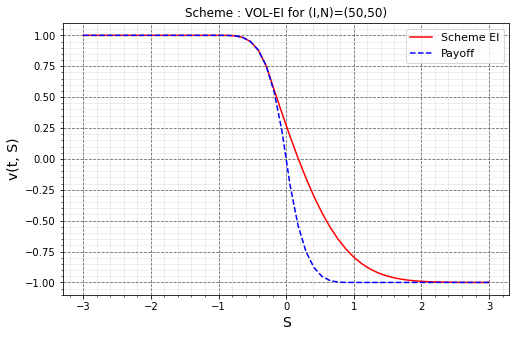

In [321]:
plot_EI_volatility_model(sigma=1.0, T=0.5, Smin=-3, Smax=3, I=50, N=50, titles="Scheme : VOL-EI for (I,N)=(50,50)")

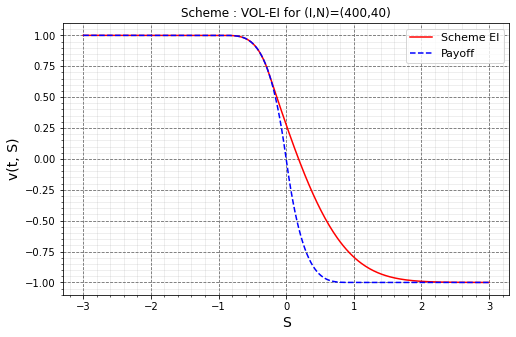

In [374]:
plot_EI_volatility_model(sigma=1.0, T=0.5, Smin=-3, Smax=3, I=400, N=40, titles="Scheme : VOL-EI for (I,N)=(400,40)")

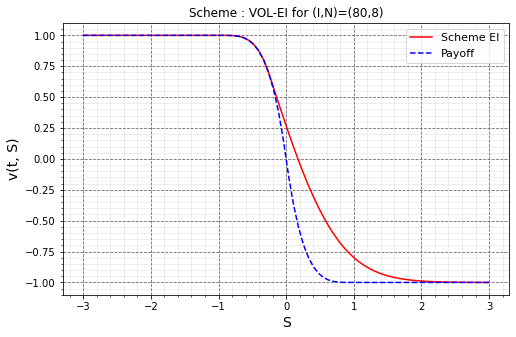

In [323]:
plot_EI_volatility_model(sigma=1.0, T=0.5, Smin=-3, Smax=3, I=80, N=8, titles="Scheme : VOL-EI for (I,N)=(80,8)")

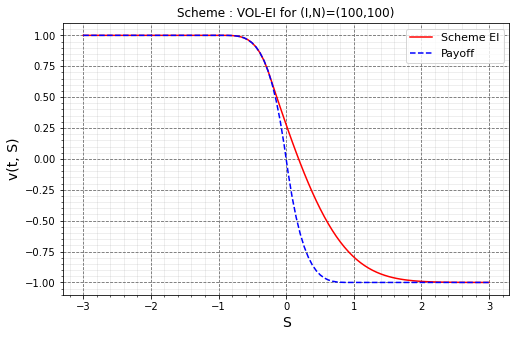

In [324]:
plot_EI_volatility_model(sigma=1.0, T=0.5, Smin=-3, Smax=3, I=100, N=100, titles="Scheme : VOL-EI for (I,N)=(100,100)")

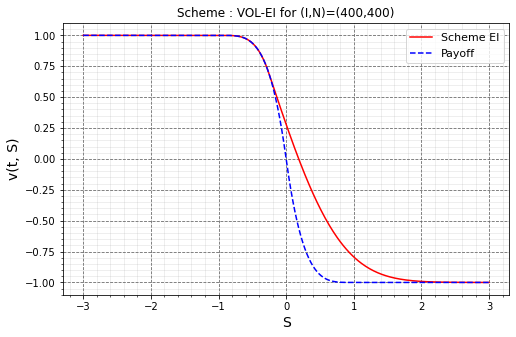

In [325]:
plot_EI_volatility_model(sigma=1.0, T=0.5, Smin=-3, Smax=3, I=400, N=400, titles="Scheme : VOL-EI for (I,N)=(400,400)")

In [286]:
def U_s_barre_EI_volatility_model(s_barre, sigma, T, Smin, Smax, I, N):
    h = (Smax - Smin)/(I+1)
    S_vect = Smin + h*np.arange(0, (I+2)) 
    U_vect = Euler_EI_volatility_model(sigma, T, Smin, Smax, I, N)
    
    s_i = 0
    s_i_plus_1 = 0
    u_i = 0
    u_i_plus_1 = 0
    
    for i in range(S_vect.size):     
        if s_barre < S_vect[i]:
            s_i = S_vect[i-1]
            s_i_plus_1 = S_vect[i]
            u_i = U_vect[i-1]
            u_i_plus_1 = U_vect[i]   
            break
    
    u_s_barre = ((s_i_plus_1 - s_barre)/h)*u_i + ((s_barre - s_i)/h)*u_i_plus_1
    
    return u_s_barre

In [580]:
U_s_barre_EI_volatility_model(s_barre=0.5, sigma=1.0, T=0.5, Smin=-3, Smax=3, I=2560, N=256)

-0.3988163702526795

In [581]:
U_s_barre_EI_volatility_model(s_barre=0.5, sigma=1.0, T=0.5, Smin=-3, Smax=3, I=2560, N=2560)

-0.39830395338344365

In [582]:
U_s_barre_EI_volatility_model(s_barre=0.5, sigma=1.0, T=0.5, Smin=-3, Smax=3, I=5120, N=512)

-0.3985312700674858

In [589]:
def create_table_EI_volatility_model(s_barre, sigma, T, Smin, Smax, I_list, N_list):
    
    def order_alpha_time(err1, err2, N1, N2):
        delta_t1 = T/N1
        delta_t2 = T/N2
        return np.log(abs(err1/err2))/np.log(abs(delta_t1/delta_t2))
    
    def order_alpha_space(err1, err2, I1, I2):
        h1 = (Smax - Smin)/(I1 + 1)
        h2 = (Smax - Smin)/(I2 + 1)
        return np.log(abs(err1/err2))/np.log(abs(h1/h2))

    
    # Création du Dataframe :
    table = pd.DataFrame(data=None, index=None, columns=['I', 'N', 'U(s)', 'error'])

    # Mise à jour des colonnes et choix de l'index :
    table.loc[:,'I'] = I_list
    table.loc[:,'N'] = N_list
    table.set_index('I')
    
    # Computation of the differents approxitions and tcpu:
    tcpu_list = []
    U_s_barre_list = []
    for I, N in zip(I_list, N_list):
        t0 = time.time()
        u = U_s_barre_EI_volatility_model(s_barre, sigma, T, Smin, Smax, I, N)
        t1 = time.time()
        U_s_barre_list.append(u)
        tcpu_list.append(t1-t0)
        

    # remplissage du dataframe :
    table.loc[:,'U(s)'] = U_s_barre_list
    
    # calcul de l'erreur :
    exact_sol = -0.3985312700674858
    table.loc[:,'error'] = table.loc[:,'U(s)'] - exact_sol
    
    # calcul de l'ordre alpha_k :
    order_alpha_k_time = [order_alpha_time(table["error"].loc[i], table["error"].loc[i+1], N_list[i], N_list[i+1]) for i in range(len(N_list)-1)]
    order_alpha_k_space = [order_alpha_space(table["error"].loc[i], table["error"].loc[i+1], I_list[i], I_list[i+1]) for i in range(len(I_list)-1)]
    for i in range(max(len(order_alpha_k_time), len(order_alpha_k_time))):
        table.at[i+1, "order alpha time"] = order_alpha_k_time[i]
        table.at[i+1, "order alpha space"] = order_alpha_k_space[i]
       
    # temps d'éxécution :
    table.loc[:,'tcpu'] = tcpu_list
        
        
    return table

In [590]:
I_list1 = [int(10*(2**k)) for k in range(7)]
N_list1 = I_list1
create_table_EI_volatility_model(s_barre=0.5, sigma=1.0, T=0.5, Smin=-3, Smax=3, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,10,-0.405853,-0.007322,NaN,NaN,0.003124
1,20,20,-0.410968,-0.012437,-0.764292,-0.819277,0.008425
2,40,40,-0.404967,-0.006435,0.950567,0.984804,0.010765
3,80,80,-0.400770,-0.002239,1.523026,1.550472,0.028516
4,160,160,-0.399406,-0.000874,1.356471,1.368698,0.163479
5,320,320,-0.398741,-0.000210,2.058712,2.067992,1.091796
6,640,640,-0.398490,0.000042,2.337880,2.343149,8.783162


In [588]:
I_list1 = [int(10*(2**k)) for k in range(7)]
N_list1 = [int(i/10) for i in I_list1]
create_table_EI_volatility_model(s_barre=0.5, sigma=1.0, T=0.5, Smin=-3, Smax=3, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,1,-0.471422,-0.073118,NaN,NaN,0.000690
1,20,2,-0.460889,-0.062585,0.224406,0.240550,0.001457
2,40,4,-0.434159,-0.035855,0.803655,0.832601,0.002831
3,80,8,-0.415961,-0.017658,1.021879,1.040295,0.006896
4,160,16,-0.407330,-0.009026,0.968116,0.976843,0.031238
5,320,32,-0.402764,-0.004460,1.017095,1.021680,0.163945
6,640,64,-0.400519,-0.002215,1.009458,1.011733,1.459578


In [297]:
I_list1 = [int(10*(2**k)) for k in range(7)]
N_list1 = [int(i/10) for i in I_list1]
create_table_EE_volatility_model(s_barre=0.5, sigma=1.0, T=0.5, Smin=-3, Smax=3, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,1,-1.696929e-01,NaN,NaN,NaN,0.001044
1,20,2,-1.426678e-01,2.702507e-02,NaN,NaN,0.001056
2,40,4,1.532060e-01,2.958738e-01,-3.452612,-3.576967,0.003198
3,80,8,5.948944e+03,5.948791e+03,-14.295327,-14.552943,0.005772
4,160,16,3.881470e+13,3.881470e+13,-32.603287,-32.897162,0.015523
5,320,32,9.909261e+40,9.909261e+40,-91.044233,-91.454626,0.073391
6,640,64,1.376116e+110,1.376116e+110,-229.686791,-230.204507,0.372131


# Example 2: Butterﬂy option pricing with uncertain volatility

## First order scheme: Euler Implicit (EI) scheme

In [628]:
def Euler_EI_butterfly(r, sigma1, sigma2, K1, K2, T, Smin, Smax, I, N):
    
    eta=1e-5 
    kmax=100 
    show_iter=False
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(1, (I+1))      
    dt = T/N
    
    def vleft(t):
        return 0.0
    
    def vright(t):
        return 0.0
    
    # the matrix A
    def get_A(sigma):
        A = np.zeros((I,I))
        for i in range(0, I):
            A[i, i] = (sigma**2)*(s[i]**2)/(h**2) + r
        for i in range(0, I-1):
            A[i, i+1] = -(sigma**2)*(s[i]**2)/(2*h**2) - r*s[i]/(2*h)
        for i in range(1, I):
            A[i, i-1] = -(sigma**2)*(s[i]**2)/(2*h**2) + r*s[i]/(2*h)
        
        return A
    
    
    # the vector function q^{+}(t)
    def get_Q1(t):
        Q = np.zeros((I,1))
        Q[0] = (-(sigma1**2)*(s[0]**2)/(2*h**2) + r*s[0]/(2*h)) * vleft(t)
        Q[I-1] = (-(sigma1**2)*(s[I-1]**2)/(2*h**2) - r*s[I-1]/(2*h)) * vright(t)
        
        return Q
    
     # the vector function q^{-}(t)
    def get_Q2(t):
        Q = np.zeros((I,1))
        Q[0] = (-(sigma2**2)*(s[0]**2)/(2*h**2) + r*s[0]/(2*h)) * vleft(t)
        Q[I-1] = (-(sigma2**2)*(s[I-1]**2)/(2*h**2) - r*s[I-1]/(2*h)) * vright(t)
        
        return Q
        
    def v0(x):
        res = np.maximum(x - K1, 0) - 2*np.maximum(x - 0.5*(K1+K2), 0) + np.maximum(x - K2, 0)
        return res.reshape(I,1)
            
    # initialization
    U = v0(s)
    Id = np.eye(I)
    
    # main loop 
    for n in range(0, N):
        t = n*dt 
        t1 = (n+1)*dt
        B1 = Id + dt*get_A(sigma1)
        B2 = Id + dt*get_A(sigma2)
            
        b1 = U - dt*get_Q1(t1)
        b2 = U - dt*get_Q2(t1)

        x = U.copy()
        xold = np.zeros((I,1))
        k = 0
        err = 1 # we start with an error >> 1e-5, so we can choose error=1
        
        while (err > eta and k < kmax):
            xold = x.copy()
            F = np.maximum(B1 @ x - b1, B2 @ x - b2)
            Fp = B2.copy()
            i, j = np.where((B1 @ x - b1) >= (B2 @ x - b2))
            Fp[i,:] = B1[i,:]
            x = x - lng.solve(Fp, F)
                
            err = lng.norm(x - xold, np.inf)
            if (show_iter):
                print("k=%s, err=%10.8f" %(k, err))
            k = k+1
        U = x
        
    U = np.insert(U, 0, vleft(T))
    U = np.insert(U, U.size, vright(T))

    return U

In [629]:
Euler_EI_butterfly(r=0.1, sigma1=0.15, sigma2=0.25, K1=90, K2=110, T=0.1, Smin=0, Smax=200, I=20, N=20)

array([0.00000000e+00, 2.66801947e-17, 2.77612509e-14, 1.12344951e-11,
       2.38173405e-09, 2.97354242e-07, 2.30335047e-05, 1.12145142e-03,
       3.34479218e-02, 5.58901500e-01, 3.97727072e+00, 3.53670406e+00,
       3.64776251e-01, 2.33471786e-02, 1.23934693e-03, 6.05710696e-05,
       2.86737888e-06, 1.35244001e-07, 6.46441399e-09, 3.16472727e-10,
       1.59194303e-11, 0.00000000e+00])

In [630]:
def plot_EI_butterfly(r, sigma1, sigma2, K1, K2, T, Smin, Smax, I, N, titles="Euler EI butterfly"):
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(0, (I+2))
    
    def v0(x):
        res = np.maximum(x - K1, 0) - 2*np.maximum(x - 0.5*(K1+K2), 0) + np.maximum(x - K2, 0)
        return res
    
    
    U = Euler_EI_butterfly(r, sigma1, sigma2, K1, K2, T, Smin, Smax, I, N)
    # Plot the data
    plt.figure(figsize=(8,5))
    plt.plot(s, U, "r", label="Scheme EI")
    plt.plot(s, v0(s), "b", ls="--", label="Payoff")

    # Show the major grid lines with dark grey lines
    plt.grid(b=True, which='major', color='#666666', linestyle='--')

    # Show the minor grid lines with very faint and almost transparent grey lines
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
    plt.title(titles)
    plt.xlabel("S", fontsize=14)
    plt.ylabel("v(t, S)", fontsize=14)
    plt.legend(fontsize=11)

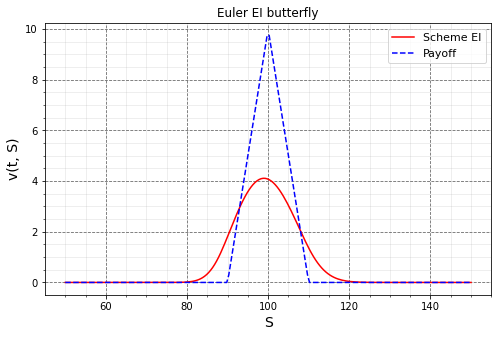

In [631]:
plot_EI_butterfly(r=0.1, sigma1=0.15, sigma2=0.25, K1=90, K2=110, T=0.1, Smin=50, Smax=150, I=200, N=200)

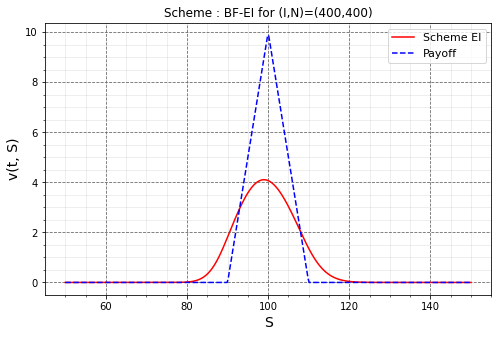

In [620]:
plot_EI_butterfly(r=0.1, sigma1=0.15, sigma2=0.25, K1=90, K2=110, T=0.1, Smin=50, Smax=150, I=400, N=400, titles="Scheme : BF-EI for (I,N)=(400,400)")

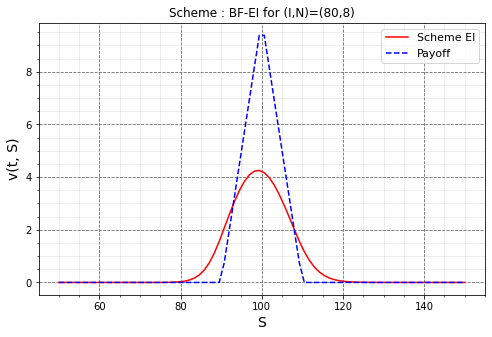

In [621]:
plot_EI_butterfly(r=0.1, sigma1=0.15, sigma2=0.25, K1=90, K2=110, T=0.1, Smin=50, Smax=150, I=80, N=8, titles="Scheme : BF-EI for (I,N)=(80,8)")

In [603]:
def U_s_barre_EI_butterfly(s_barre, r, sigma1, sigma2, K1, K2, T, Smin, Smax, I, N):
    h = (Smax - Smin)/(I+1)
    S_vect = Smin + h*np.arange(0, (I+2)) 
    U_vect = Euler_EI_butterfly(r, sigma1, sigma2, K1, K2, T, Smin, Smax, I, N)
    
    s_i = 0
    s_i_plus_1 = 0
    u_i = 0
    u_i_plus_1 = 0
    
    for i in range(S_vect.size):     
        if s_barre < S_vect[i]:
            s_i = S_vect[i-1]
            s_i_plus_1 = S_vect[i]
            u_i = U_vect[i-1]
            u_i_plus_1 = U_vect[i]   
            break
    
    u_s_barre = ((s_i_plus_1 - s_barre)/h)*u_i + ((s_barre - s_i)/h)*u_i_plus_1
    
    return u_s_barre

In [604]:
def create_table_EI_butterfly(s_barre, r, sigma1, sigma2, K1, K2, T, Smin, Smax, I_list, N_list):
    
    def order_alpha_time(err1, err2, N1, N2):
        delta_t1 = T/N1
        delta_t2 = T/N2
        return np.log(abs(err1/err2))/np.log(abs(delta_t1/delta_t2))
    
    def order_alpha_space(err1, err2, I1, I2):
        h1 = (Smax - Smin)/(I1 + 1)
        h2 = (Smax - Smin)/(I2 + 1)
        return np.log(abs(err1/err2))/np.log(abs(h1/h2))

    
    # Création du Dataframe :
    table = pd.DataFrame(data=None, index=None, columns=['I', 'N', 'U(s)', 'error'])

    # Mise à jour des colonnes et choix de l'index :
    table.loc[:,'I'] = I_list
    table.loc[:,'N'] = N_list
    table.set_index('I')
    
    # Computation of the differents approxitions and tcpu:
    tcpu_list = []
    U_s_barre_list = []
    for I, N in zip(I_list, N_list):
        t0 = time.time()
        u = U_s_barre_EI_butterfly(s_barre, r, sigma1, sigma2, K1, K2, T, Smin, Smax, I, N)
        t1 = time.time()
        U_s_barre_list.append(u)
        tcpu_list.append(t1-t0)
        

    # remplissage du dataframe :
    table.loc[:,'U(s)'] = U_s_barre_list
    
    # calcul de l'erreur :
    table.loc[:,'error'] = table.loc[:,'U(s)'].diff()
    
    # calcul de l'ordre alpha_k :
    order_alpha_k_time = [order_alpha_time(table["error"].loc[i], table["error"].loc[i+1], N_list[i], N_list[i+1]) for i in range(len(N_list)-1)]
    order_alpha_k_space = [order_alpha_space(table["error"].loc[i], table["error"].loc[i+1], I_list[i], I_list[i+1]) for i in range(len(I_list)-1)]
    for i in range(max(len(order_alpha_k_time), len(order_alpha_k_time))):
        table.at[i+1, "order alpha time"] = order_alpha_k_time[i]
        table.at[i+1, "order alpha space"] = order_alpha_k_space[i]
       
    # temps d'éxécution :
    table.loc[:,'tcpu'] = tcpu_list
        
        
    return table

In [632]:
I_list1 = [int(10*(2**k)) for k in range(7)]
N_list1 = [int(i/10) for i in I_list1]
create_table_EI_butterfly(s_barre=100, r=0.1, sigma1=0.15, sigma2=0.25, K1=90, K2=110, T=0.1, Smin=50, Smax=150, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,1,4.035820,NaN,NaN,NaN,0.003111
1,20,2,4.458703,0.422883,NaN,NaN,0.001827
2,40,4,4.324904,-0.133799,1.660191,1.719987,0.003858
3,80,8,4.211041,-0.113863,0.232773,0.236968,0.010316
4,160,16,4.141649,-0.069392,0.714445,0.720885,0.048173
5,320,32,4.104878,-0.036771,0.916215,0.920345,0.272313
6,640,64,4.086052,-0.018826,0.965819,0.967996,2.088023


In [633]:
I_list1 = [int(10*(2**k)) for k in range(7)]
N_list1 = I_list1
create_table_EI_butterfly(s_barre=100, r=0.1, sigma1=0.15, sigma2=0.25, K1=90, K2=110, T=0.1, Smin=50, Smax=150, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,10,3.817557,NaN,NaN,NaN,0.004031
1,20,20,4.090095,0.272538,NaN,NaN,0.008163
2,40,40,4.084462,-0.005633,5.596477,5.798048,0.030108
3,80,80,4.079545,-0.004917,0.196003,0.199535,0.075858
4,160,160,4.073923,-0.005621,-0.193083,-0.194824,0.449421
5,320,320,4.070611,-0.003312,0.763281,0.766721,1.973947
6,640,640,4.068823,-0.001789,0.888626,0.890629,13.683525


In [608]:
I_list1 = [25, 50, 100, 200, 300, 400, 500]
N_list1 = I_list1
create_table_EI_butterfly(s_barre=100, r=0.1, sigma1=0.15, sigma2=0.25, K1=90, K2=110, T=0.1, Smin=50, Smax=150, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,25,25,4.382843,NaN,NaN,NaN,0.016325
1,50,50,4.085792,-0.297051,NaN,NaN,0.034773
2,100,100,4.077515,-0.008277,5.165436,5.239915,0.108802
3,200,200,4.072611,-0.004904,0.755189,0.760635,0.643165
4,300,300,4.070837,-0.001774,2.507772,2.518079,1.281582
5,400,400,4.069906,-0.000931,2.240707,2.247198,2.600284
6,500,500,4.069332,-0.000574,2.167834,2.172692,4.594233


## Second order scheme: BDF2

In [634]:
def Euler_BDF2_butterfly(r, sigma1, sigma2, K1, K2, T, Smin, Smax, I, N):
    
    eta=1e-5 
    kmax=100 
    show_iter=False
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(1, (I+1))      
    dt = T/N
    
    def vleft(t):
        return 0.0
    
    def vright(t):
        return 0.0
    
    # the matrix A
    def get_A(sigma):
        A = np.zeros((I,I))
        for i in range(0, I):
            A[i, i] = (sigma**2)*(s[i]**2)/(h**2) + r
        for i in range(0, I-1):
            A[i, i+1] = -(sigma**2)*(s[i]**2)/(2*h**2) - r*s[i]/(2*h)
        for i in range(1, I):
            A[i, i-1] = -(sigma**2)*(s[i]**2)/(2*h**2) + r*s[i]/(2*h)
        
        return A
    
    
    # the vector function q^{+}(t)
    def get_Q1(t):
        Q = np.zeros((I,1))
        Q[0] = (-(sigma1**2)*(s[0]**2)/(2*h**2) + r*s[0]/(2*h)) * vleft(t)
        Q[I-1] = (-(sigma1**2)*(s[I-1]**2)/(2*h**2) - r*s[I-1]/(2*h)) * vright(t)
        
        return Q
    
     # the vector function q^{-}(t)
    def get_Q2(t):
        Q = np.zeros((I,1))
        Q[0] = (-(sigma2**2)*(s[0]**2)/(2*h**2) + r*s[0]/(2*h)) * vleft(t)
        Q[I-1] = (-(sigma2**2)*(s[I-1]**2)/(2*h**2) - r*s[I-1]/(2*h)) * vright(t)
        
        return Q
        
    def v0(x):
        res = np.maximum(x - K1, 0) - 2*np.maximum(x - 0.5*(K1+K2), 0) + np.maximum(x - K2, 0)
        return res.reshape(I,1)
            
    # initialization
    U = v0(s)
    Id = np.eye(I)
    
    # main loop 
    for n in range(0, N):
        t = n*dt 
        t1 = (n+1)*dt
        
        if (n==0):
            B1 = Id + dt*get_A(sigma1)
            B2 = Id + dt*get_A(sigma2)
            b1 = U - dt*get_Q1(t1)
            b2 = U - dt*get_Q2(t1)

            x = U.copy()
            xold = np.zeros((I,1))
            k = 0
            err = 1 # we start with an error >> 1e-5, so we can choose error=1
        
            while (err > eta and k < kmax):
                xold = x.copy()
                F = np.maximum(B1 @ x - b1, B2 @ x - b2)
                Fp = B2.copy()
                i, j = np.where((B1 @ x - b1) >= (B2 @ x - b2))
                Fp[i,:] = B1[i,:]
                x = x - lng.solve(Fp, F)
                
                err = lng.norm(x - xold, np.inf)
                if (show_iter):
                    print("k=%s, err=%10.8f" %(k, err))
                k = k+1
            U = x
            U_moins = U.copy()
        
        else:
            
            B1_ = 3*Id + 2*dt*get_A(sigma1)
            B2_ = 3*Id + 2*dt*get_A(sigma2)
            b1_ = 4*U - U_moins - 2*dt*get_Q1(t1)
            b2_ = 4*U - U_moins - 2*dt*get_Q2(t1)
            
            x_ = U.copy()
            U_inter = U.copy()
            xold_ = np.zeros((I,1))
            
            k_ = 0
            err_ = 1 # we start with an error >> 1e-5, so we can choose error=1

            while (err_ > eta and k_ < kmax):
                xold_ = x_.copy()
                F = np.maximum(B1_ @ x_ - b1_, B2_ @ x_ - b2_)
                Fp = B2_.copy()
                i, j = np.where((B1_ @ x_ - b1_) >= (B2_ @ x_ - b2_))
                Fp[i,:] = B1_[i,:]
                x_ = x_ - lng.solve(Fp, F)

                err_ = lng.norm(x_ - xold_, np.inf)
                if (show_iter):
                    print("k=%s, err=%10.8f" %(k_, err_))
                k_ = k_+1
            U = x_.copy()
            U_moins = U_inter.copy()

    U = np.insert(U, 0, vleft(T))
    U = np.insert(U, U.size, vright(T))

    return U

In [635]:
Euler_BDF2_butterfly(r=0.1, sigma1=0.15, sigma2=0.25, K1=90, K2=110, T=0.1, Smin=0, Smax=200, I=20, N=20)

array([0.00000000e+00, 7.29625685e-18, 9.57550249e-15, 4.81891341e-12,
       1.24960959e-09, 1.87154477e-07, 1.69975135e-05, 9.44370772e-04,
       3.11245953e-02, 5.53090256e-01, 3.99696149e+00, 3.55243841e+00,
       3.63147541e-01, 2.20482006e-02, 1.07124116e-03, 4.65148542e-05,
       1.90820243e-06, 7.63800100e-08, 3.04405107e-09, 1.22419375e-10,
       5.00184387e-12, 0.00000000e+00])

In [638]:
def plot_BDF2_butterfly(r, sigma1, sigma2, K1, K2, T, Smin, Smax, I, N, titles="Euler BDF2 butterfly"):
    h = (Smax - Smin)/(I+1)
    s = Smin + h*np.arange(0, (I+2))
    
    def v0(x):
        res = np.maximum(x - K1, 0) - 2*np.maximum(x - 0.5*(K1+K2), 0) + np.maximum(x - K2, 0)
        return res
    
    
    U = Euler_BDF2_butterfly(r, sigma1, sigma2, K1, K2, T, Smin, Smax, I, N)
    # Plot the data
    plt.figure(figsize=(8,5))
    plt.plot(s, U, "r", label="Scheme EI-BDF2")
    plt.plot(s, v0(s), "b", ls="--", label="Payoff")

    # Show the major grid lines with dark grey lines
    plt.grid(b=True, which='major', color='#666666', linestyle='--')

    # Show the minor grid lines with very faint and almost transparent grey lines
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
    plt.title(titles)
    plt.xlabel("S", fontsize=14)
    plt.ylabel("v(t, S)", fontsize=14)
    plt.legend(fontsize=11)

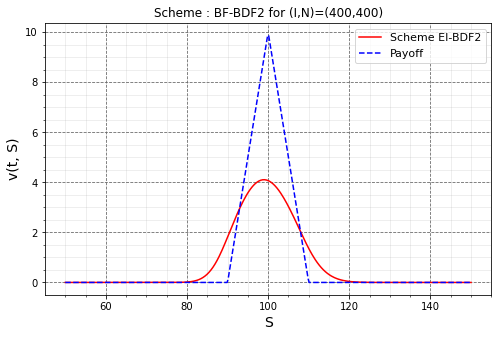

In [639]:
plot_BDF2_butterfly(r=0.1, sigma1=0.15, sigma2=0.25, K1=90, K2=110, T=0.1, Smin=50, Smax=150, I=400, N=400, titles="Scheme : BF-BDF2 for (I,N)=(400,400)")

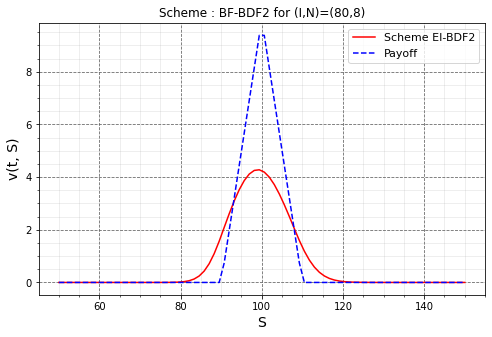

In [648]:
plot_BDF2_butterfly(r=0.1, sigma1=0.15, sigma2=0.25, K1=90, K2=110, T=0.1, Smin=50, Smax=150, I=80, N=8, titles="Scheme : BF-BDF2 for (I,N)=(80,8)")

In [641]:
def U_s_barre_BDF2_butterfly(s_barre, r, sigma1, sigma2, K1, K2, T, Smin, Smax, I, N):
    h = (Smax - Smin)/(I+1)
    S_vect = Smin + h*np.arange(0, (I+2)) 
    U_vect = Euler_BDF2_butterfly(r, sigma1, sigma2, K1, K2, T, Smin, Smax, I, N)
    
    s_i = 0
    s_i_plus_1 = 0
    u_i = 0
    u_i_plus_1 = 0
    
    for i in range(S_vect.size):     
        if s_barre < S_vect[i]:
            s_i = S_vect[i-1]
            s_i_plus_1 = S_vect[i]
            u_i = U_vect[i-1]
            u_i_plus_1 = U_vect[i]   
            break
    
    u_s_barre = ((s_i_plus_1 - s_barre)/h)*u_i + ((s_barre - s_i)/h)*u_i_plus_1
    
    return u_s_barre

In [642]:
def create_table_BDF2_butterfly(s_barre, r, sigma1, sigma2, K1, K2, T, Smin, Smax, I_list, N_list):
    
    def order_alpha_time(err1, err2, N1, N2):
        delta_t1 = T/N1
        delta_t2 = T/N2
        return np.log(abs(err1/err2))/np.log(abs(delta_t1/delta_t2))
    
    def order_alpha_space(err1, err2, I1, I2):
        h1 = (Smax - Smin)/(I1 + 1)
        h2 = (Smax - Smin)/(I2 + 1)
        return np.log(abs(err1/err2))/np.log(abs(h1/h2))

    
    # Création du Dataframe :
    table = pd.DataFrame(data=None, index=None, columns=['I', 'N', 'U(s)', 'error'])

    # Mise à jour des colonnes et choix de l'index :
    table.loc[:,'I'] = I_list
    table.loc[:,'N'] = N_list
    table.set_index('I')
    
    # Computation of the differents approxitions and tcpu:
    tcpu_list = []
    U_s_barre_list = []
    for I, N in zip(I_list, N_list):
        t0 = time.time()
        u = U_s_barre_BDF2_butterfly(s_barre, r, sigma1, sigma2, K1, K2, T, Smin, Smax, I, N)
        t1 = time.time()
        U_s_barre_list.append(u)
        tcpu_list.append(t1-t0)
        

    # remplissage du dataframe :
    table.loc[:,'U(s)'] = U_s_barre_list
    
    # calcul de l'erreur :
    table.loc[:,'error'] = table.loc[:,'U(s)'].diff()
    
    # calcul de l'ordre alpha_k :
    order_alpha_k_time = [order_alpha_time(table["error"].loc[i], table["error"].loc[i+1], N_list[i], N_list[i+1]) for i in range(len(N_list)-1)]
    order_alpha_k_space = [order_alpha_space(table["error"].loc[i], table["error"].loc[i+1], I_list[i], I_list[i+1]) for i in range(len(I_list)-1)]
    for i in range(max(len(order_alpha_k_time), len(order_alpha_k_time))):
        table.at[i+1, "order alpha time"] = order_alpha_k_time[i]
        table.at[i+1, "order alpha space"] = order_alpha_k_space[i]
       
    # temps d'éxécution :
    table.loc[:,'tcpu'] = tcpu_list
        
        
    return table

In [643]:
I_list1 = [25*2**k for k in range(5)]
N_list1 = [60*2**k for k in range(5)]
create_table_BDF2_butterfly(s_barre=100, r=0.1, sigma1=0.15, sigma2=0.25, K1=90, K2=110, T=0.1, Smin=50, Smax=150, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,25,60,4.350648,NaN,NaN,NaN,0.025703
1,50,120,4.070925,-0.279723,NaN,NaN,0.101674
2,100,240,4.069803,-0.001121,7.962776,8.077589,0.298626
3,200,480,4.068714,-0.001090,0.041198,0.041496,1.681539
4,400,960,4.067949,-0.000765,0.510659,0.512501,11.761754


In [644]:
I_list1 = [int(10*(2**k)) for k in range(7)]
N_list1 = I_list1
create_table_BDF2_butterfly(s_barre=100, r=0.1, sigma1=0.15, sigma2=0.25, K1=90, K2=110, T=0.1, Smin=50, Smax=150, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,10,3.858052,NaN,NaN,NaN,0.013716
1,20,20,4.093780,0.235728,NaN,NaN,0.009090
2,40,40,4.083195,-0.010585,4.477002,4.638253,0.029513
3,80,80,4.078000,-0.005194,1.027029,1.045537,0.087404
4,160,160,4.073026,-0.004975,0.062343,0.062905,0.490489
5,320,320,4.070137,-0.002888,0.784403,0.787939,1.957636
6,640,640,4.068580,-0.001558,0.890905,0.892913,17.650732


In [646]:
I_list1 = [int(10*(2**k)) for k in range(7)]
N_list1 = [int(i/10) for i in I_list1]
create_table_BDF2_butterfly(s_barre=100, r=0.1, sigma1=0.15, sigma2=0.25, K1=90, K2=110, T=0.1, Smin=50, Smax=150, I_list=I_list1, N_list=N_list1)

,I,N,U(s),error,order alpha time,order alpha space,tcpu
0,10,1,4.035820,NaN,NaN,NaN,0.000810
1,20,2,4.759163,0.723343,NaN,NaN,0.001749
2,40,4,4.475658,-0.283505,1.351305,1.399976,0.004208
3,80,8,4.233923,-0.241735,0.229949,0.234093,0.013328
4,160,16,4.141165,-0.092759,1.381872,1.394328,0.059418
5,320,32,4.102172,-0.038992,1.250299,1.255934,0.289880
6,640,64,4.084127,-0.018046,1.111529,1.114035,1.573058
